In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, SVR
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from xgboost import XGBClassifier


#import scikitplot.plotters as skplt
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import gensim
from category_encoders import TargetEncoder
import re


import os
import random
import warnings
random.seed(42)
warnings.filterwarnings('ignore')


In [2]:
#pip install category_encoders

In [3]:
movies_df = pd.read_excel('Training sheet.xlsx')
X_predict = pd.read_excel('Scoring Sheet.xlsx')
movies_df.head(2)

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9


In [4]:
movies_df.shape

(1196, 15)

In [5]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   id                                  1196 non-null   int64 
 1   name                                1196 non-null   object
 2   display_name                        1196 non-null   object
 3   production_year                     1196 non-null   int64 
 4   movie_sequel                        1196 non-null   int64 
 5   creative_type                       1196 non-null   object
 6   source                              1196 non-null   object
 7   production_method                   1196 non-null   object
 8   genre                               1196 non-null   object
 9   language                            1196 non-null   object
 10  board_rating_reason                 1196 non-null   object
 11  movie_board_rating_display_name     1196 non-null   obje

In [6]:
movies_df.describe()

,id,production_year,movie_sequel,total,Category
count,1.196000e+03,1196.000000,1196.000000,1196.000000,1196.000000
mean,8.928203e+07,2008.984950,0.097826,104.703177,3.564381
std,4.832893e+07,1.383625,0.297204,181.927715,1.962417
min,7.011500e+04,2007.000000,0.000000,1.000000,1.000000
25%,4.808012e+07,2008.000000,0.000000,11.000000,2.000000
50%,9.391012e+07,2009.000000,0.000000,40.500000,3.000000
75%,1.354326e+08,2010.000000,0.000000,114.250000,5.000000
max,1.769701e+08,2011.000000,1.000000,2784.000000,9.000000


In [7]:
movies_df.describe(include='O')

,name,display_name,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name
count,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196
unique,1196,1195,9,16,6,13,16,1003,6,7
top,"Messenger, The",Death at a Funeral,Contemporary Fiction,Original Screenplay,Live Action,Drama,English,International - to be excluded,R,Wide
freq,1,2,638,629,1093,321,1144,83,448,795


In [8]:
movies_df.describe(include='all')

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
count,1.196000e+03,1196,1196,1196.000000,1196.000000,1196,1196,1196,1196,1196,1196,1196,1196,1196.000000,1196.000000
unique,NaN,1196,1195,NaN,NaN,9,16,6,13,16,1003,6,7,NaN,NaN
top,NaN,"Messenger, The",Death at a Funeral,NaN,NaN,Contemporary Fiction,Original Screenplay,Live Action,Drama,English,International - to be excluded,R,Wide,NaN,NaN
freq,NaN,1,2,NaN,NaN,638,629,1093,321,1144,83,448,795,NaN,NaN
mean,8.928203e+07,NaN,NaN,2008.984950,0.097826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.703177,3.564381
std,4.832893e+07,NaN,NaN,1.383625,0.297204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.927715,1.962417
min,7.011500e+04,NaN,NaN,2007.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,4.808012e+07,NaN,NaN,2008.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,2.000000
50%,9.391012e+07,NaN,NaN,2009.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.500000,3.000000
75%,1.354326e+08,NaN,NaN,2010.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.250000,5.000000


In [9]:
movies_df.isnull().sum()

id                                    0
name                                  0
display_name                          0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
total                                 0
Category                              0
dtype: int64

In [10]:
print('The Feature name                    :    Distinct values')
print('--------------------------------------------------------')
for feature in movies_df.columns:
    print('{:<35} : {:>10}'.format(feature, len(movies_df[feature].unique())))


The Feature name                    :    Distinct values
--------------------------------------------------------
id                                  :       1196
name                                :       1196
display_name                        :       1195
production_year                     :          5
movie_sequel                        :          2
creative_type                       :          9
source                              :         16
production_method                   :          6
genre                               :         13
language                            :         16
board_rating_reason                 :       1003
movie_board_rating_display_name     :          6
movie_release_pattern_display_name  :          7
total                               :        324
Category                            :          9


In [11]:
movies_df['production_year'] = movies_df['production_year'].astype('str')
X_predict['production_year'] = X_predict['production_year'].astype('str')

In [12]:
stop_words = stopwords.words('english')

def preprocess_rating_reason_text(board_rating_reason):
    if type(board_rating_reason) is str:
        board_rating_reason_wo_spclchars_lower = re.sub('[^a-zA-Z0-9\n]', ' ', str(board_rating_reason)).lower()
        after_stop_words = [word for word in board_rating_reason_wo_spclchars_lower.split() if word not in stop_words]
        cleaned_text = ' '.join(after_stop_words)
    return cleaned_text

movies_df['board_rating_reason'] = movies_df['board_rating_reason'].apply(preprocess_rating_reason_text)
X_predict['board_rating_reason'] = X_predict['board_rating_reason'].apply(preprocess_rating_reason_text)
print(len(movies_df['board_rating_reason'].unique()), len(X_predict['board_rating_reason'].unique()) )

911 79


In [13]:
movies_df.dtypes

id                                     int64
name                                  object
display_name                          object
production_year                       object
movie_sequel                           int64
creative_type                         object
source                                object
production_method                     object
genre                                 object
language                              object
board_rating_reason                   object
movie_board_rating_display_name       object
movie_release_pattern_display_name    object
total                                  int64
Category                               int64
dtype: object

In [14]:
categorical_features = ['production_year', 'creative_type', 'source', 'production_method',
                        'genre', 'language', 'movie_board_rating_display_name', 
                        'movie_release_pattern_display_name']

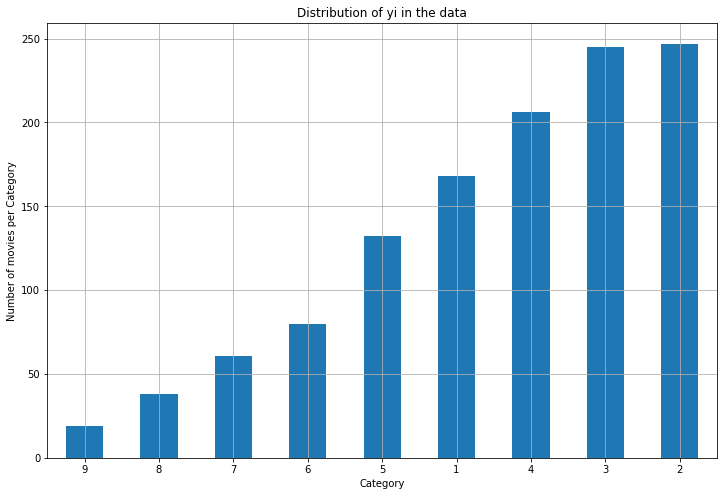

In [15]:
category_distribution = movies_df['Category'].value_counts().sort_values()
plt.figure(figsize=(12,8))
category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of movies per Category')
plt.title('Distribution of yi in the data')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [16]:
# split into X and y
train_features = ['id', 'name', 'display_name', 'production_year', 'movie_sequel', 'creative_type', 'source',
                  'production_method', 'genre', 'language', 'board_rating_reason', 
                  'movie_board_rating_display_name', 'movie_release_pattern_display_name', 'total', 'Category']
X = movies_df.loc[:, train_features]

y = movies_df['Category']

In [17]:
X.head(2)

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,intense epic battle sequences warfare sensuali...,PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,sequences intense action violence frightening ...,PG-13,Wide,1328,9


In [18]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify = y )

In [19]:
X_train.shape,  X_test.shape, y_train.shape, y_test.shape 

((1076, 15), (120, 15), (1076,), (120,))

In [20]:
train_category_distribution = y_train.value_counts().sort_values()
test_category_distribution  = y_test.value_counts().sort_values()


In [21]:
train_category_distribution

9     17
8     34
7     55
6     72
5    119
1    151
4    185
3    221
2    222
Name: Category, dtype: int64

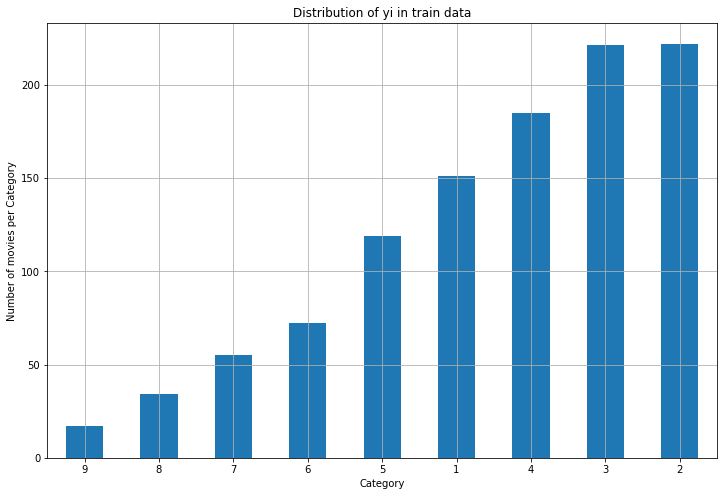

In [22]:
plt.figure(figsize=(12,8))
train_category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of movies per Category')
plt.title('Distribution of yi in train data')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [23]:
sorted_yi = np.argsort(-train_category_distribution.values)
for i in sorted_yi:
    print('Number of movies in category', i+1, ':',train_category_distribution.values[i], '(', np.round((train_category_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

Number of movies in category 9 : 222 ( 20.632 %)
Number of movies in category 8 : 221 ( 20.539 %)
Number of movies in category 7 : 185 ( 17.193 %)
Number of movies in category 6 : 151 ( 14.033 %)
Number of movies in category 5 : 119 ( 11.059 %)
Number of movies in category 4 : 72 ( 6.691 %)
Number of movies in category 3 : 55 ( 5.112 %)
Number of movies in category 2 : 34 ( 3.16 %)
Number of movies in category 1 : 17 ( 1.58 %)


In [24]:
test_category_distribution

9     2
8     4
7     6
6     8
5    13
1    17
4    21
3    24
2    25
Name: Category, dtype: int64

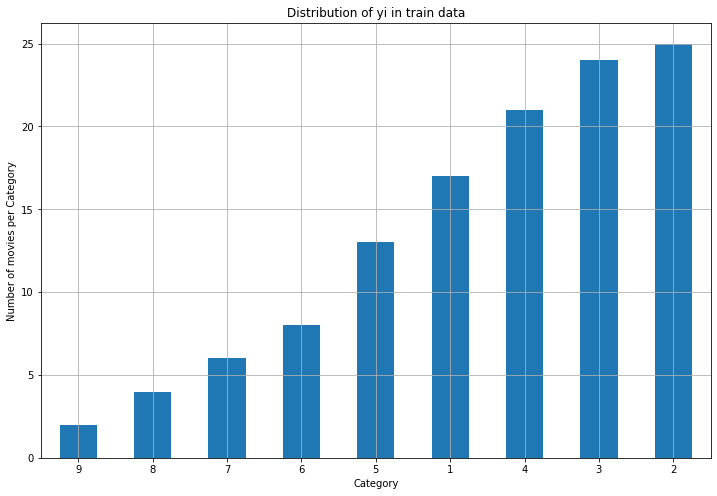

In [25]:
plt.figure(figsize=(12,8))
test_category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of movies per Category')
plt.title('Distribution of yi in train data')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [26]:
sorted_yi = np.argsort(-test_category_distribution.values)
for i in sorted_yi:
    print('Number of data points in category', i+1, ':',test_category_distribution.values[i], '(', np.round((test_category_distribution.values[i]/X_test.shape[0]*100), 3), '%)')

Number of data points in category 9 : 25 ( 20.833 %)
Number of data points in category 8 : 24 ( 20.0 %)
Number of data points in category 7 : 21 ( 17.5 %)
Number of data points in category 6 : 17 ( 14.167 %)
Number of data points in category 5 : 13 ( 10.833 %)
Number of data points in category 4 : 8 ( 6.667 %)
Number of data points in category 3 : 6 ( 5.0 %)
Number of data points in category 2 : 4 ( 3.333 %)
Number of data points in category 1 : 2 ( 1.667 %)


In [27]:
def rating_mean_by_feature(feature):
    distinct_feature_values = X_train[feature].unique()
    rating_means_dict = {}
    for distinct_feature_value in distinct_feature_values:
        value_group = X_train[X_train[feature] == distinct_feature_value]
        rating_means_dict[distinct_feature_value] = value_group['Category'].mean()
    
    return rating_means_dict

In [28]:
def plot_rating_mean_by_feature(feature_means_dict):
    plt.figure(figsize=(14,10))
    plt.bar(range(len(feature_means_dict)), list(feature_means_dict.values()), align='center')
    plt.xticks(range(len(feature_means_dict)), list(feature_means_dict.keys()), rotation=90)
    plt.ylabel('Average Rating')
    plt.show()

**Evaluating individual features**

Now we will look at each feature independently for ensuring its relavncy to the the target feature by understanding 
each feature, its distribution 



In [29]:
def feature_values_distribution(feature):
    
    labels = X_train[feature].astype('category').cat.categories.tolist()
    counts = X_train[feature].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    fig1, ax1 = plt.subplots(figsize=(12,10))
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')#, shadow=True) #autopct is show the % on plot
    ax1.axis('equal')
    plt.title('Cumulative distribution of feature: {}'.format(feature))
    plt.show()

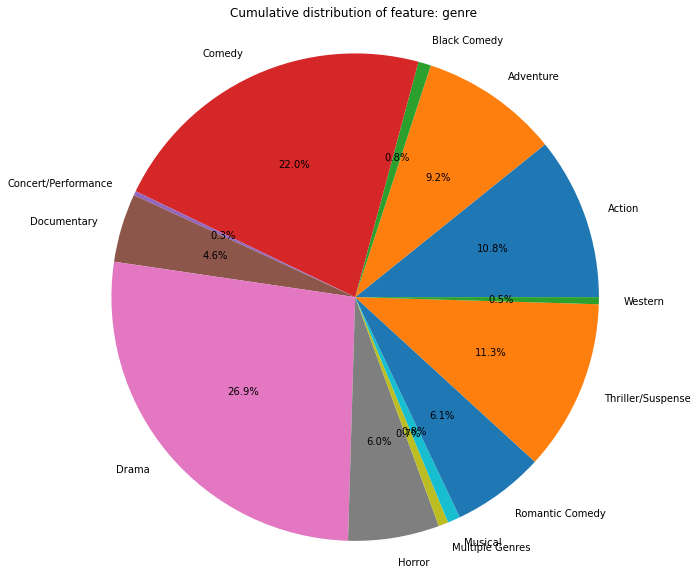

In [30]:
feature_values_distribution('genre')

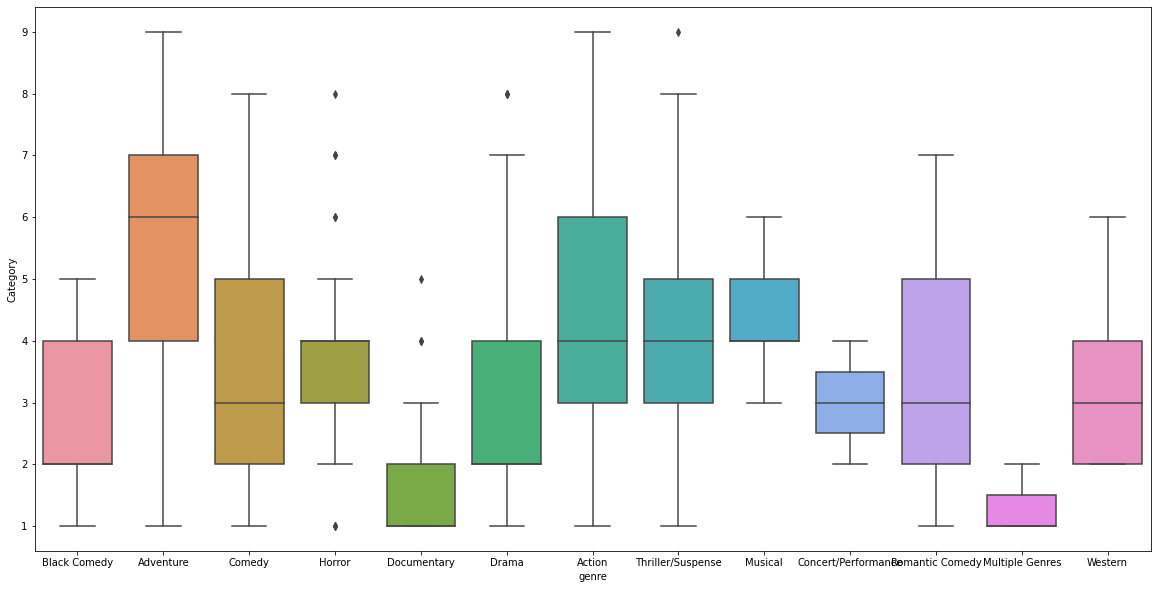

In [31]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='genre', y=y_train, data=X_train)
plt.show()

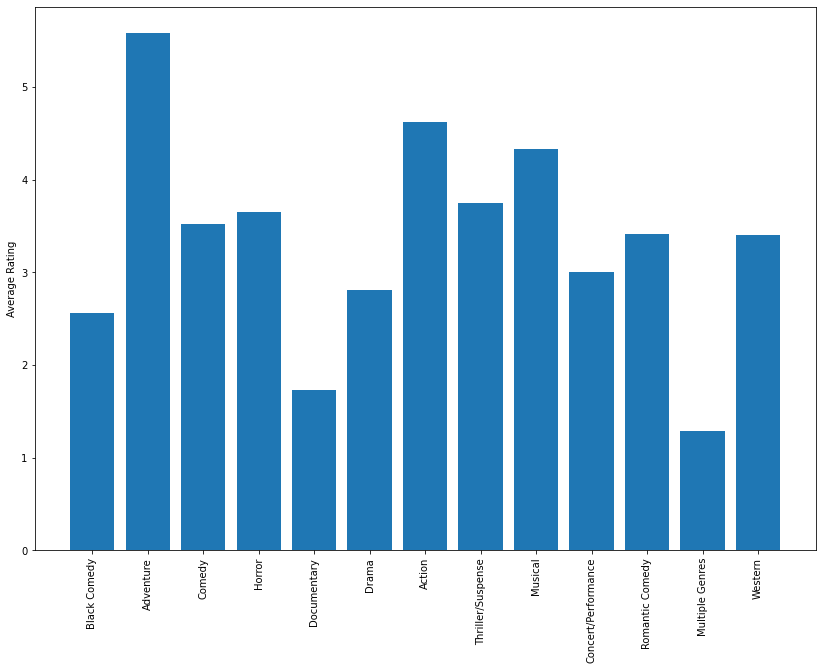

In [32]:
genre_means = rating_mean_by_feature('genre')
plot_rating_mean_by_feature(genre_means)

In [33]:
genre_means 

{'Black Comedy': 2.5555555555555554,
 'Adventure': 5.585858585858586,
 'Comedy': 3.518987341772152,
 'Horror': 3.646153846153846,
 'Documentary': 1.7346938775510203,
 'Drama': 2.8062283737024223,
 'Action': 4.620689655172414,
 'Thriller/Suspense': 3.7459016393442623,
 'Musical': 4.333333333333333,
 'Concert/Performance': 3.0,
 'Romantic Comedy': 3.409090909090909,
 'Multiple Genres': 1.2857142857142858,
 'Western': 3.4}

In [34]:
unique_genres = X_train.genre.value_counts()
print('Number of Unique Genres :', unique_genres.shape[0])
# the top 10 genes that occured most
print(unique_genres.head(10))

Number of Unique Genres : 13
Drama                289
Comedy               237
Thriller/Suspense    122
Action               116
Adventure             99
Romantic Comedy       66
Horror                65
Documentary           49
Musical                9
Black Comedy           9
Name: genre, dtype: int64


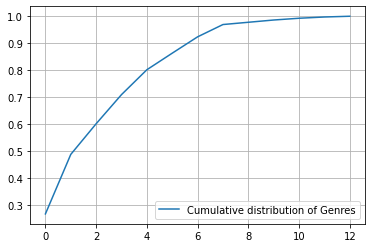

In [35]:
s = sum(unique_genres.values);
h = unique_genres.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genres')
plt.grid()
plt.legend()
plt.show()

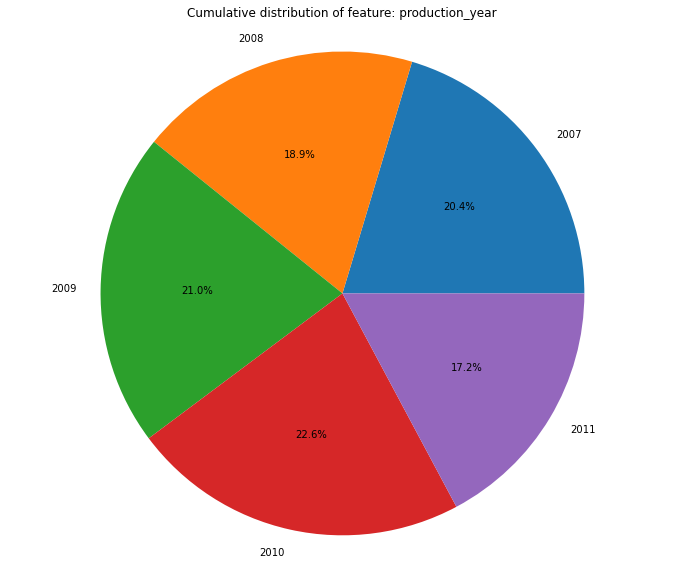

In [36]:
feature_values_distribution('production_year')

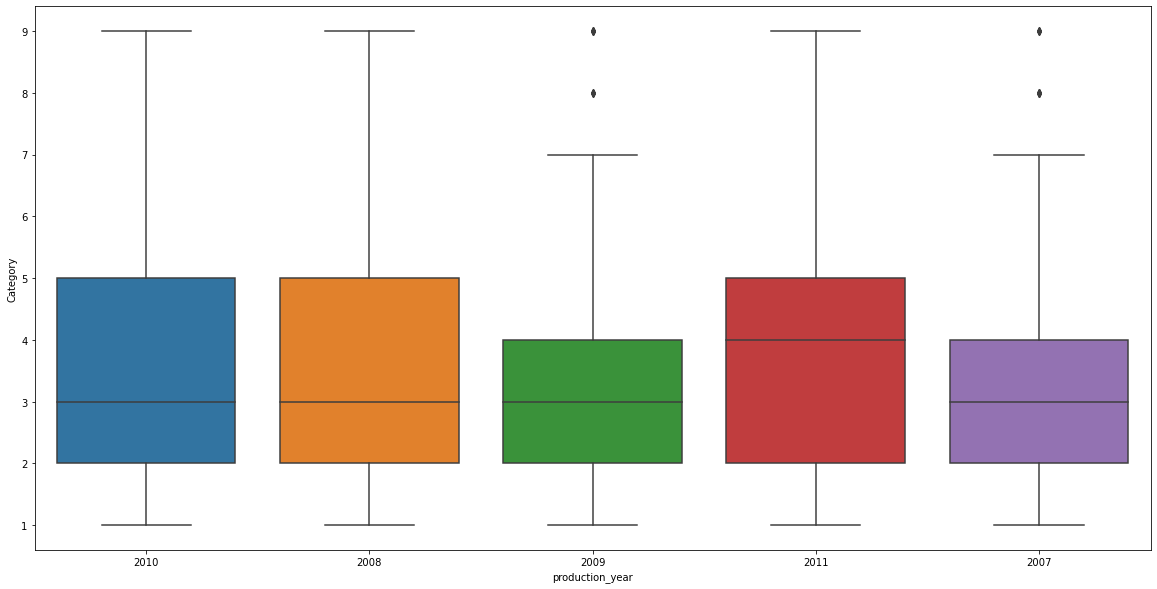

In [37]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='production_year', y=y_train, data=X_train)
plt.show()

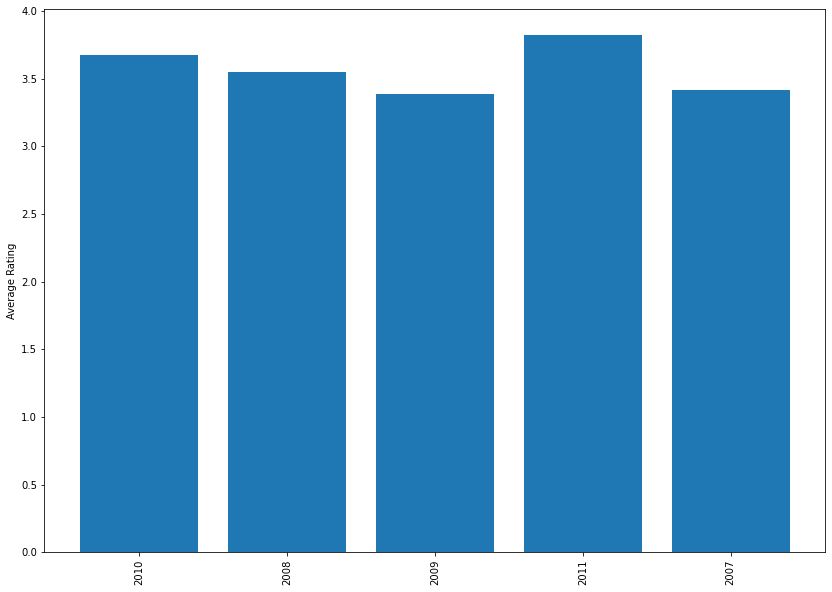

In [38]:
production_year_means = rating_mean_by_feature('production_year')
plot_rating_mean_by_feature(production_year_means)

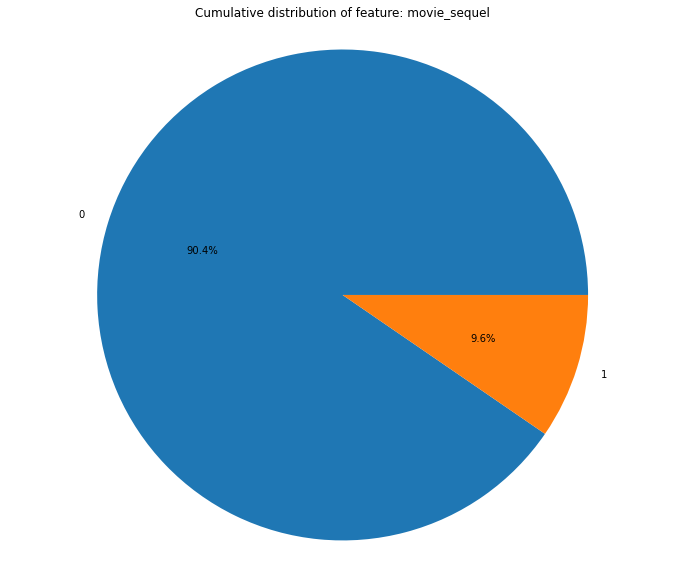

In [39]:
feature_values_distribution('movie_sequel')

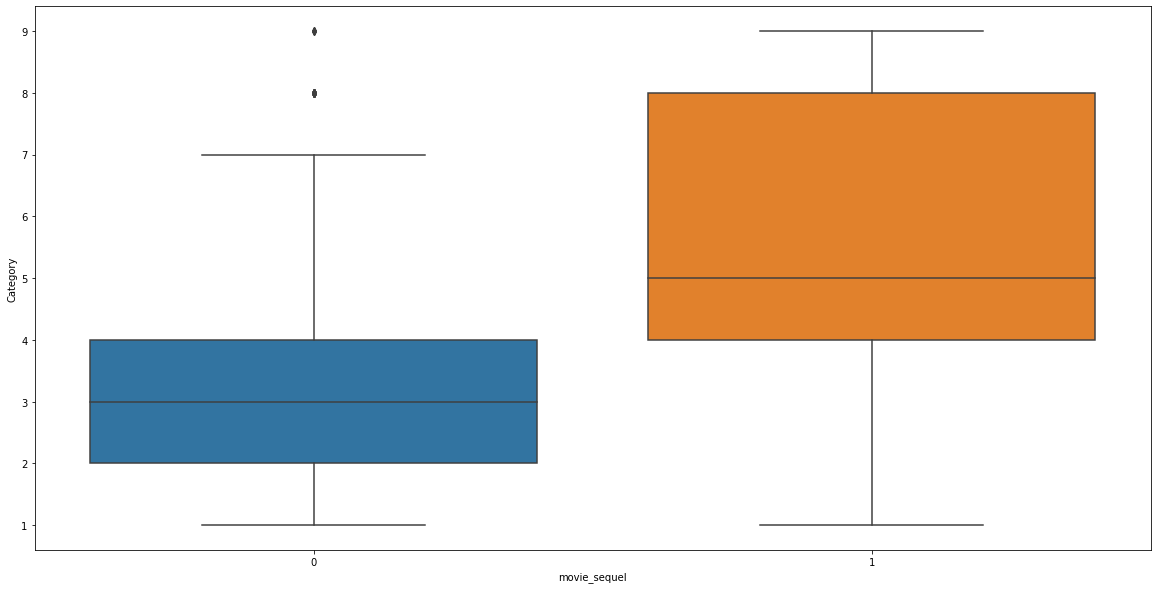

In [40]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='movie_sequel', y=y_train, data=X_train)
plt.show()

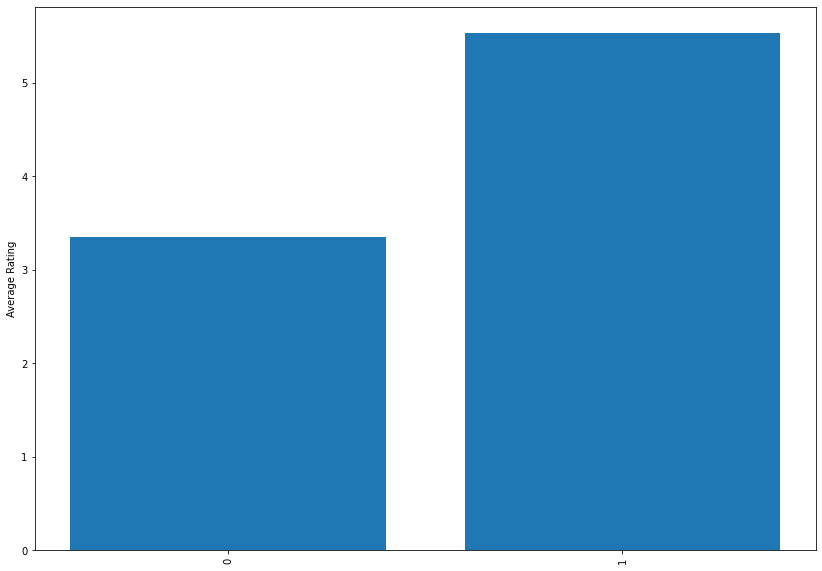

In [41]:
movie_sequel_means = rating_mean_by_feature('movie_sequel')
plot_rating_mean_by_feature(movie_sequel_means)

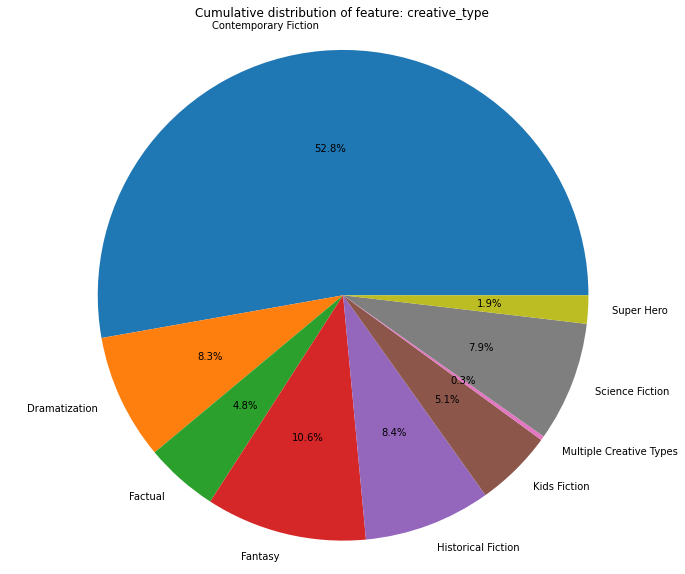

In [42]:
feature_values_distribution('creative_type')

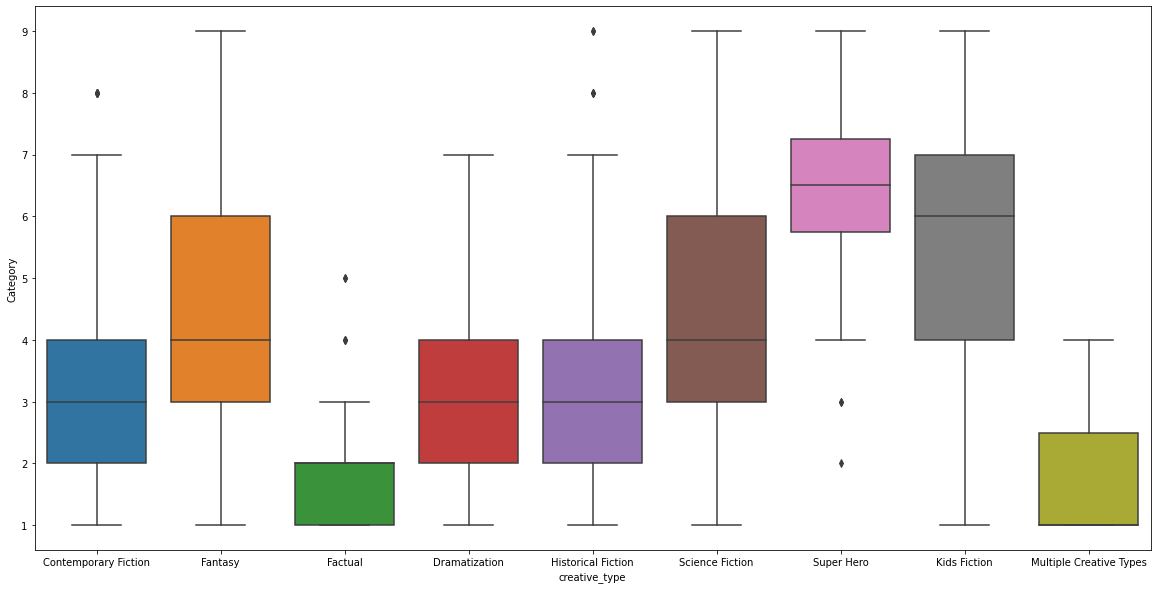

In [43]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='creative_type', y=y_train, data=X_train)
plt.show()

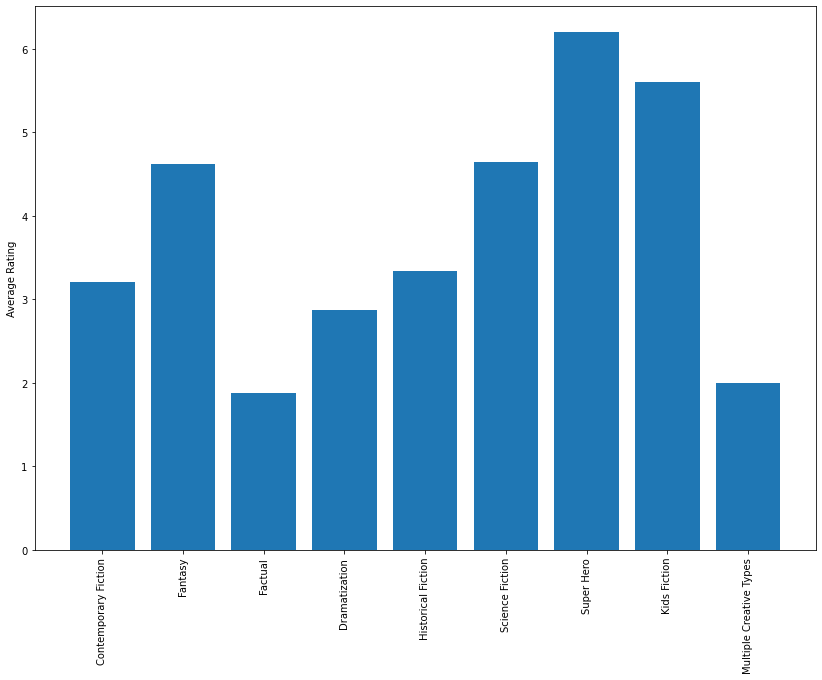

In [44]:
creative_type_means = rating_mean_by_feature('creative_type')
plot_rating_mean_by_feature(creative_type_means)

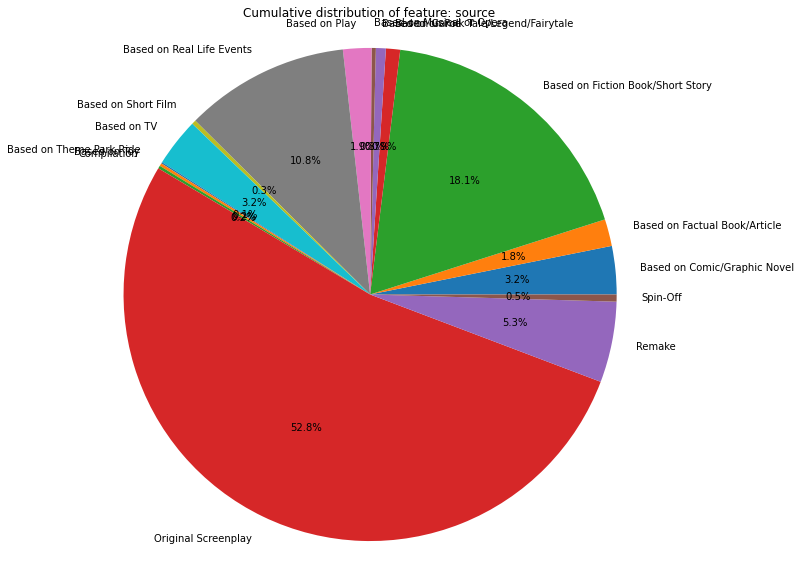

In [45]:
feature_values_distribution('source')

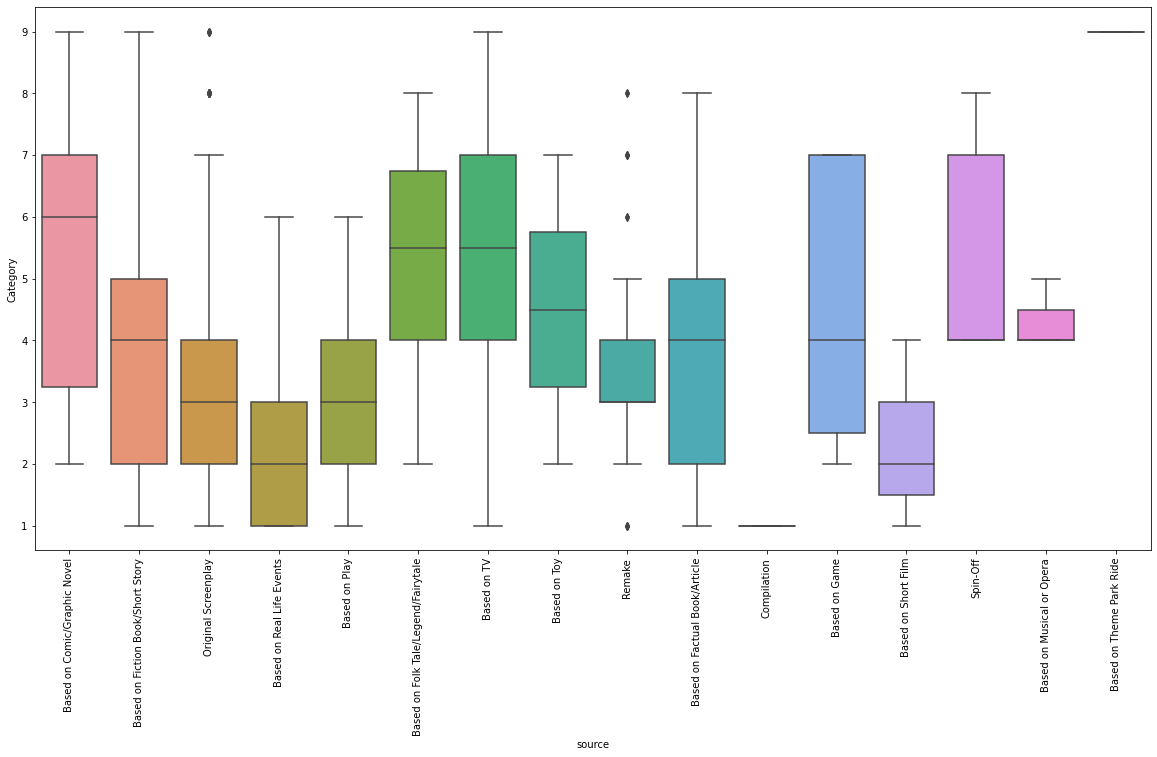

In [46]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='source', y=y_train, data=X_train)
plt.xticks(rotation=90)
plt.show()

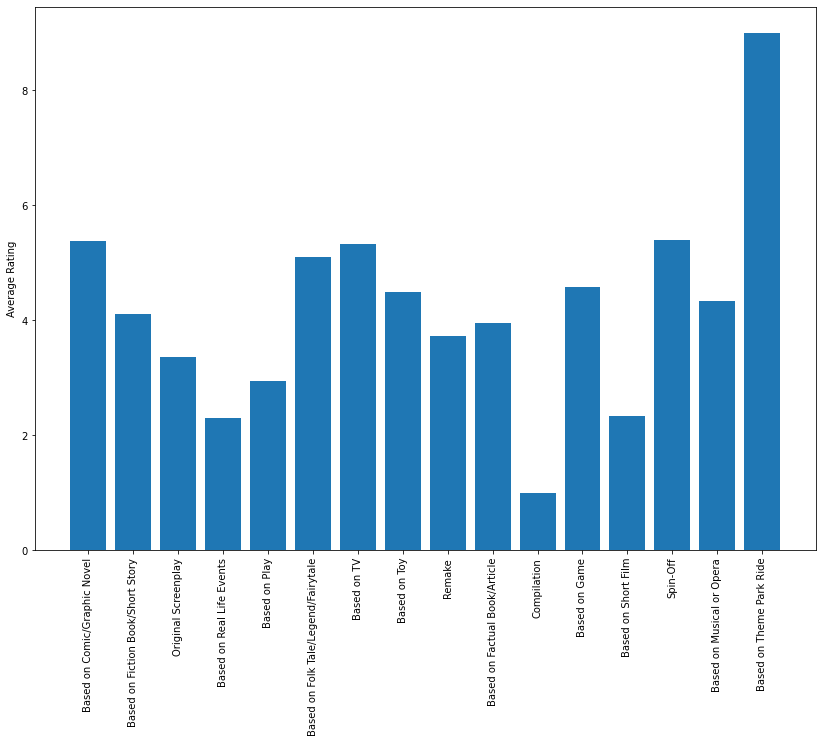

In [47]:
source_type_means = rating_mean_by_feature('source')
plot_rating_mean_by_feature(source_type_means)

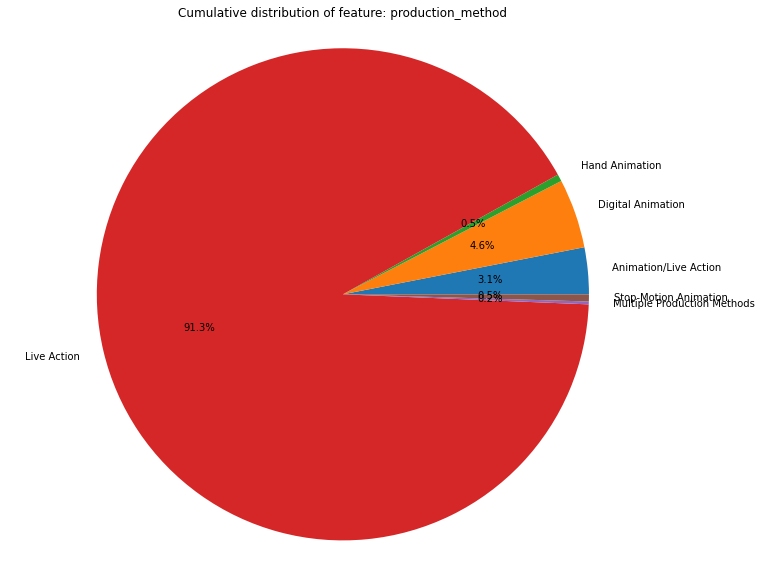

In [48]:
feature_values_distribution('production_method')

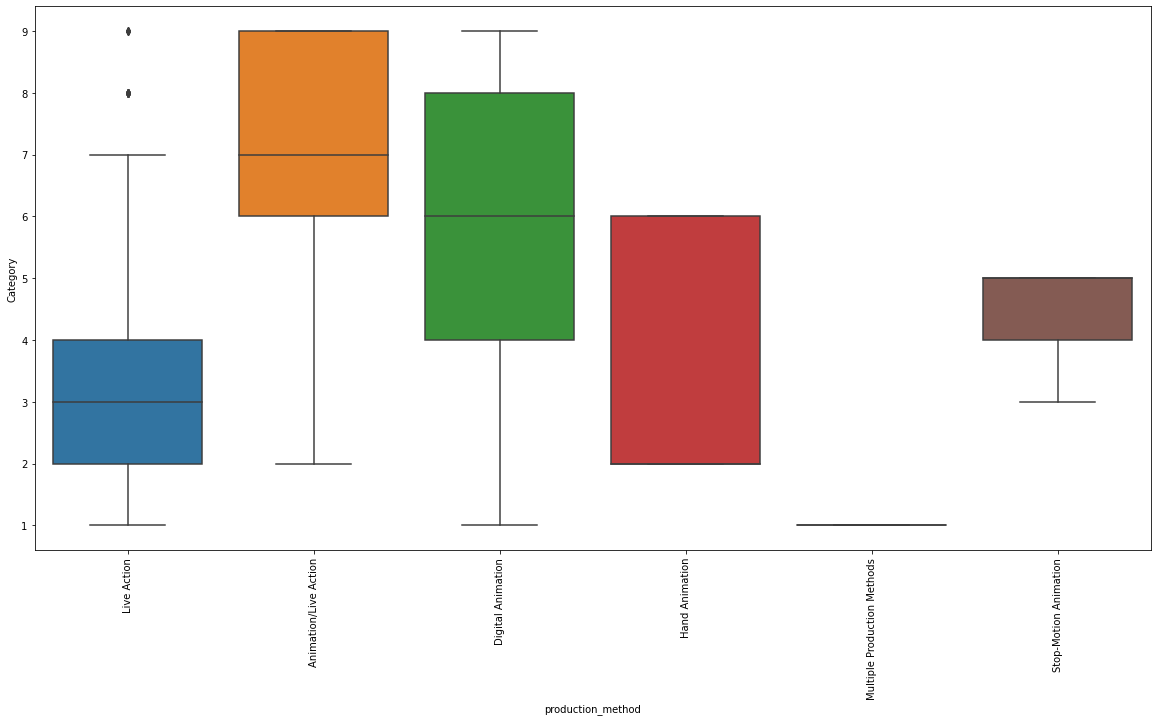

In [49]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='production_method', y=y_train, data=X_train)
plt.xticks(rotation=90)
plt.show()

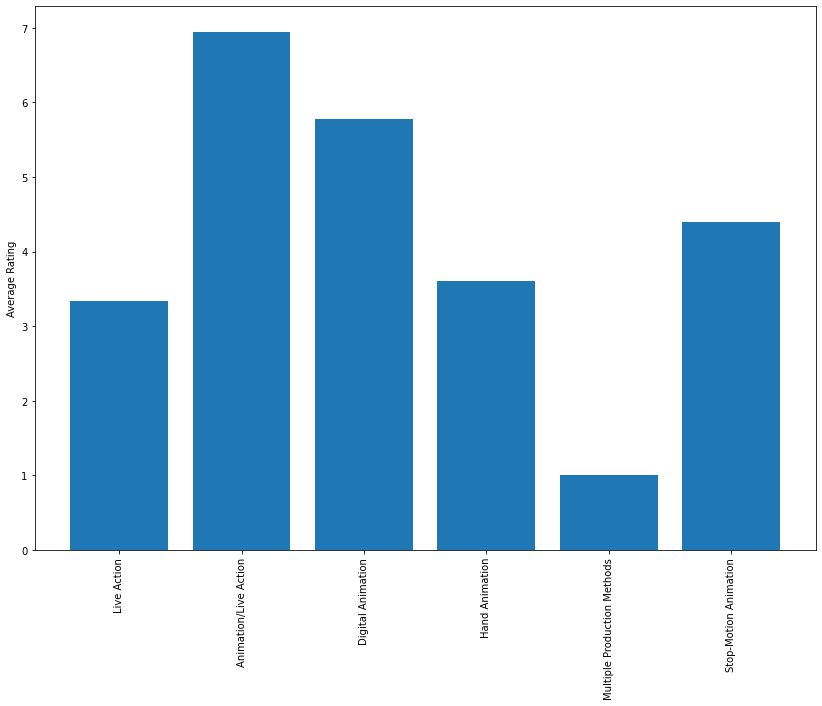

In [50]:
production_method_means = rating_mean_by_feature('production_method')
plot_rating_mean_by_feature(production_method_means)

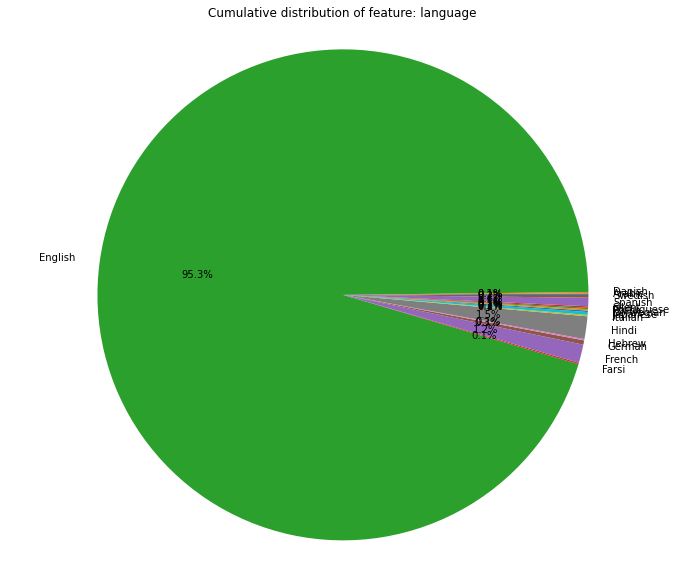

In [51]:
feature_values_distribution('language')

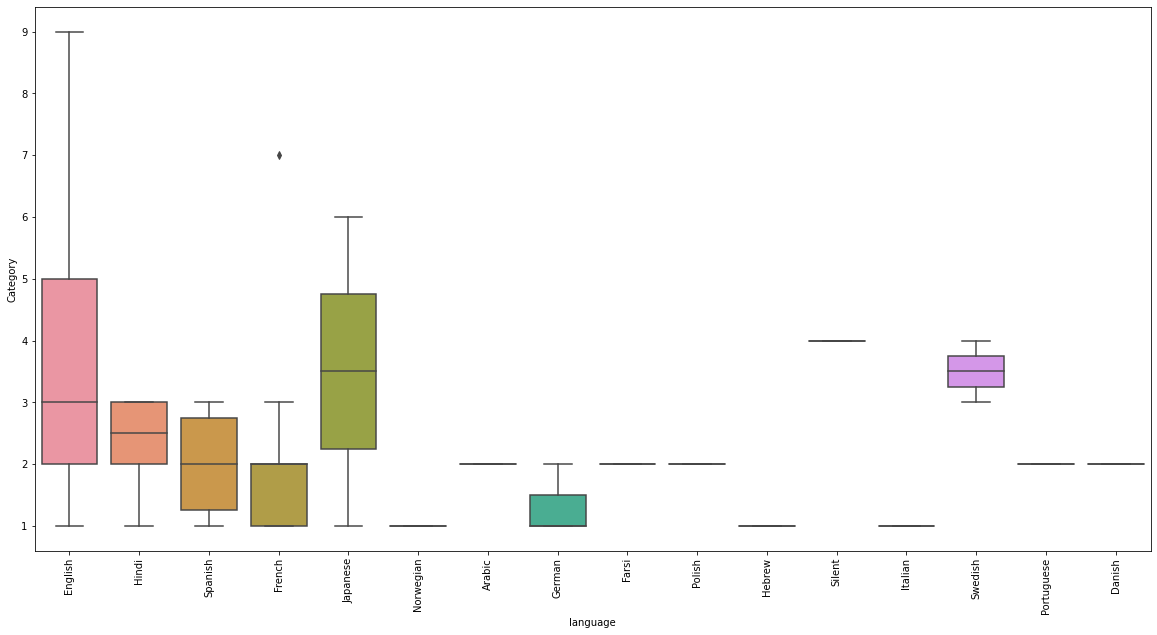

In [52]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='language', y=y_train, data=X_train)
plt.xticks(rotation=90)
plt.show()

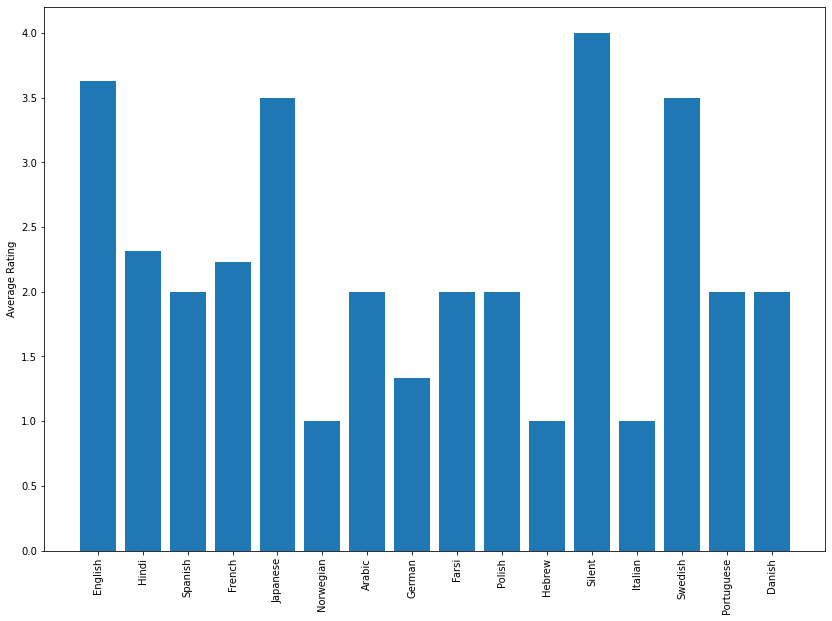

In [53]:
language_means = rating_mean_by_feature('language')
plot_rating_mean_by_feature(language_means)

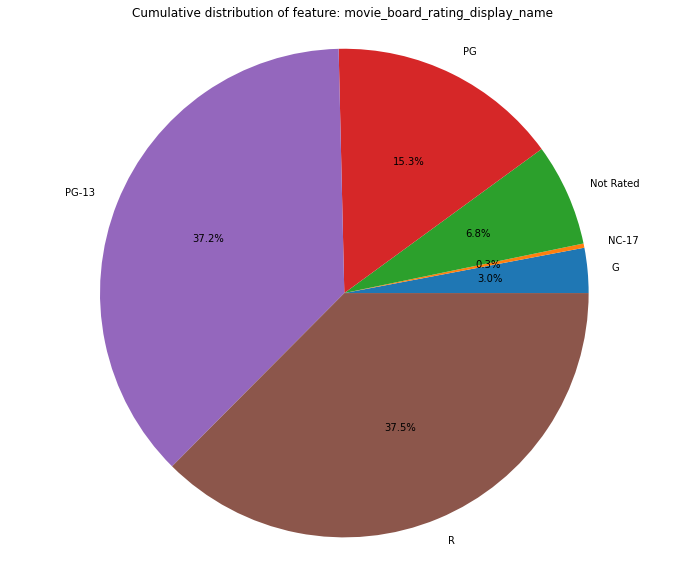

In [54]:
feature_values_distribution('movie_board_rating_display_name')

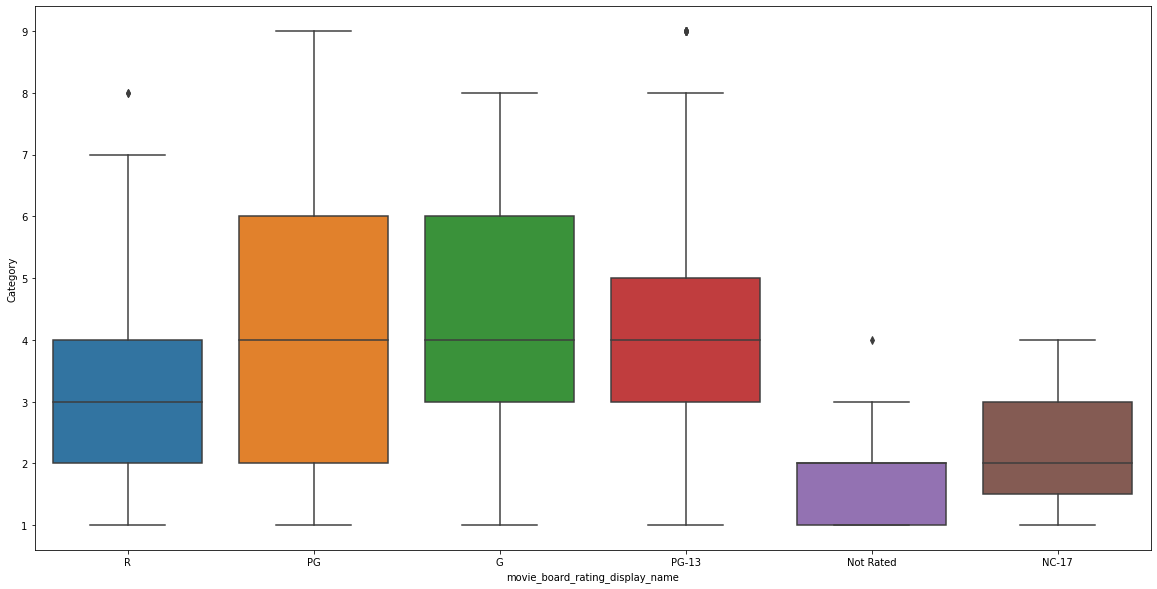

In [55]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='movie_board_rating_display_name', y=y_train, data=X_train)
#plt.xticks(rotation=90)
plt.show()

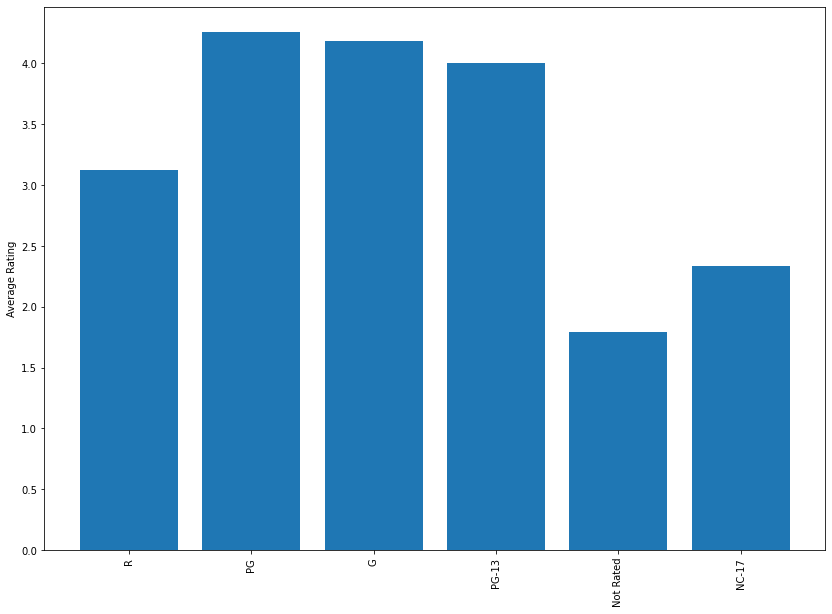

In [56]:
movie_board_rating_display_name_means = rating_mean_by_feature('movie_board_rating_display_name')
plot_rating_mean_by_feature(movie_board_rating_display_name_means)

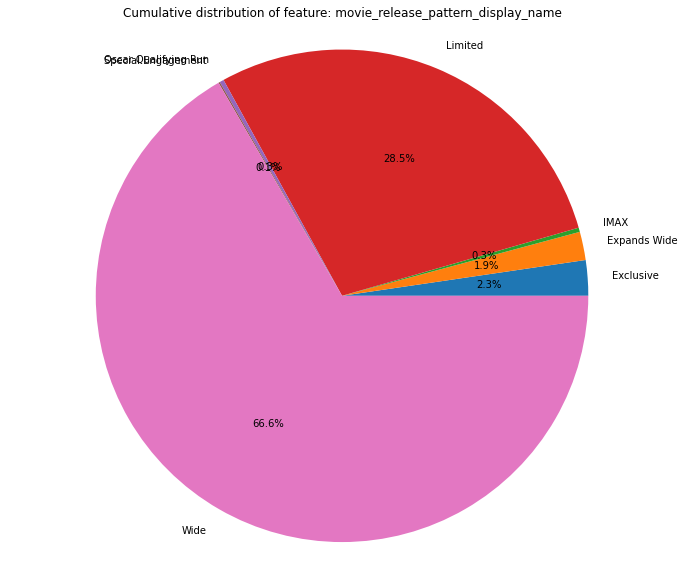

In [57]:
feature_values_distribution('movie_release_pattern_display_name')

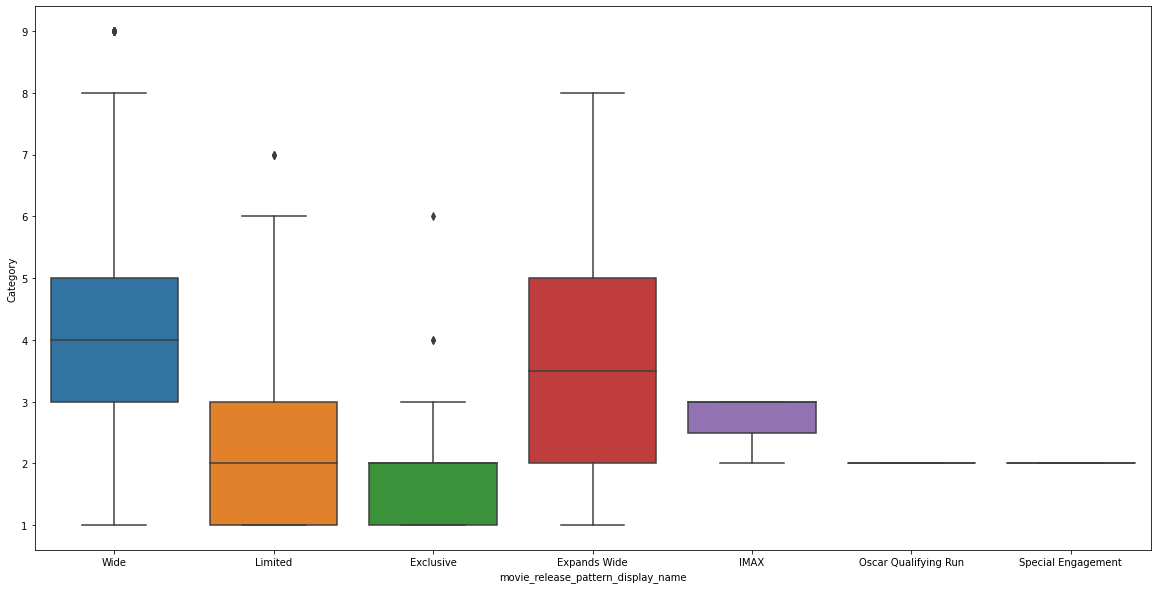

In [58]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x='movie_release_pattern_display_name', y=y_train, data=X_train)
#plt.xticks(rotation=90)
plt.show()

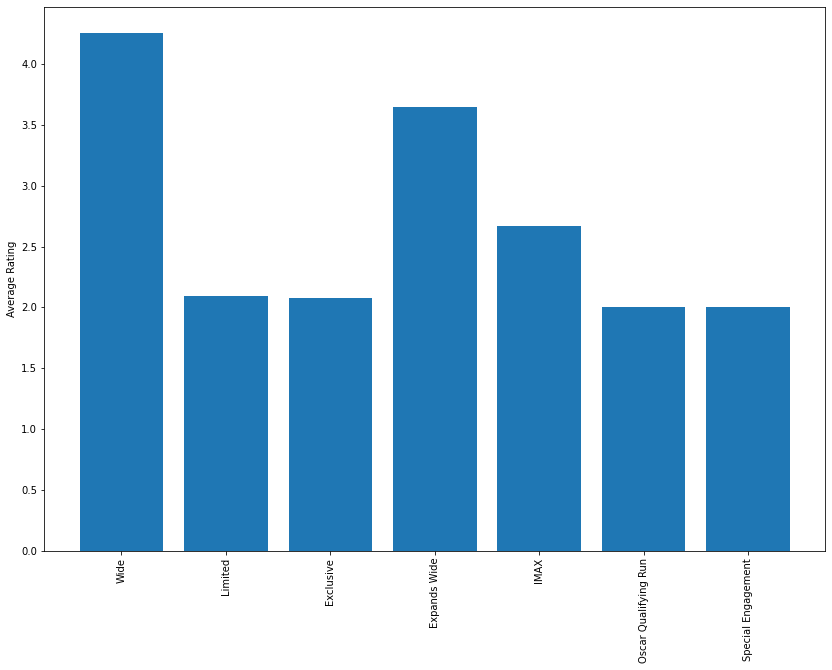

In [59]:
movie_release_pattern_display_name_means = rating_mean_by_feature('movie_release_pattern_display_name')
plot_rating_mean_by_feature(movie_release_pattern_display_name_means)

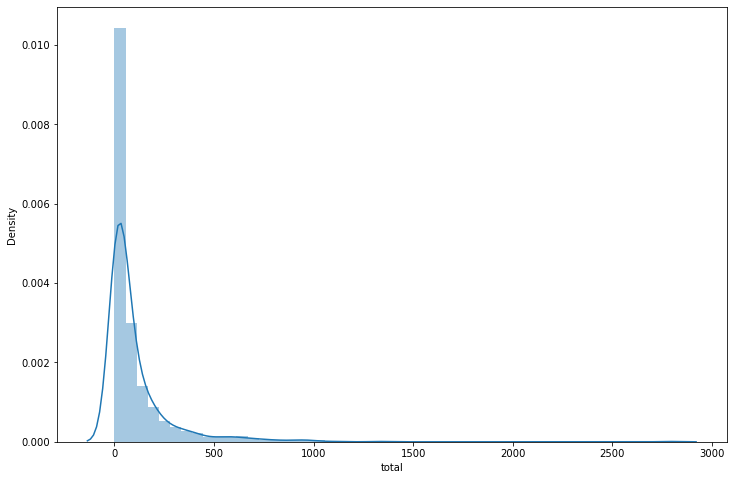

In [60]:
plt.figure(figsize=(12,8))
sns.distplot(X_train['total'])
plt.show()


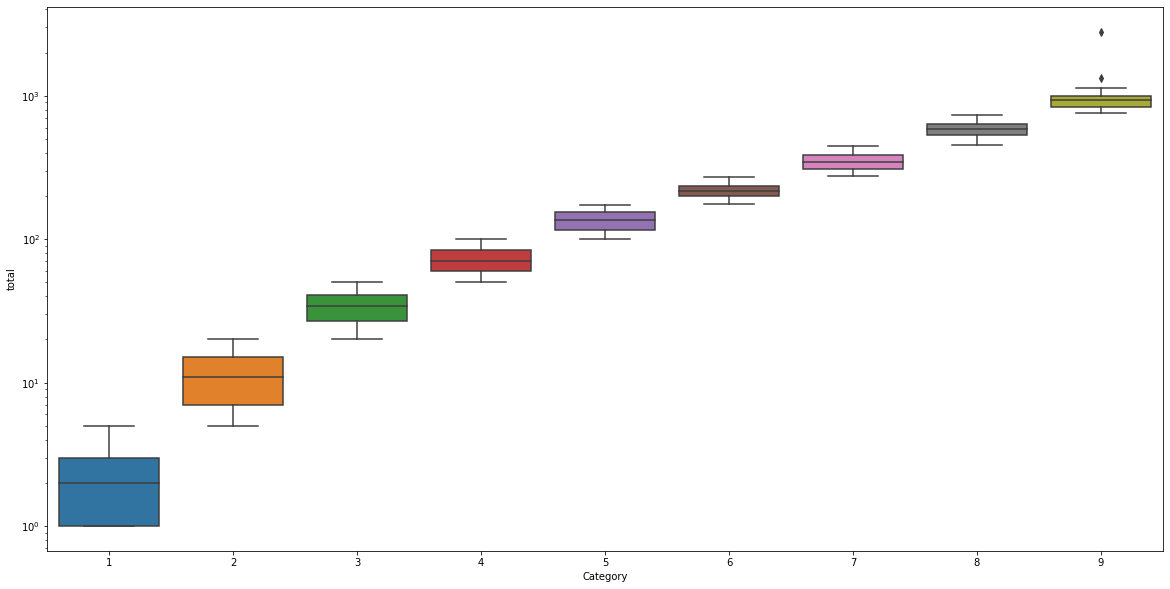

In [61]:
# comparing summary stats across nine categories
plt.figure(figsize=(20,10))
sns.boxplot(x=y_train, y='total', data=X_train)
plt.yscale('log')
plt.show()

## Total and Category seem to be correlated so let's verify the relationship

In [62]:
X_train[['Category', 'total']].corr()

,Category,total
Category,1.000000,0.801622
total,0.801622,1.000000


## Yup, but we don't have it for the predicted data, so let's build a regression model for getting it for X_predict, so can we have a regression model for it but ...

## Many Categorical features, so what about getting dummies for them?

In [63]:
X_train_categorical_dummies    = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_test_categorical_dummies     = pd.get_dummies(X_test[categorical_features], drop_first=True)
X_predict_categorical_dummies  = pd.get_dummies(X_predict[categorical_features], drop_first=True)
print('X_train categorical dummies shape: {}'.format(X_train_categorical_dummies.shape))
print('X_test categorical dummies shape: {}'.format(X_test_categorical_dummies.shape))
print('X_predict categorical dummies shape: {}'.format(X_predict_categorical_dummies.shape))

X_train categorical dummies shape: (1076, 70)
X_test categorical dummies shape: (120, 48)
X_predict categorical dummies shape: (91, 39)


In [64]:
print('Disperencies in unique value for categorical features in train and test data'.format(feature))
print('Feature name: \t\t\t\t\t\t\t train \t\t\t test \t\t predict')
print('---'*38)
for feature in categorical_features:
    print('{:<35}: {:>30} ,  {:>20} , ,  {:>10}'.format(feature, len(X_train[feature].unique()),
                                                        len(X_test[feature].unique()), 
                                                        len(X_predict[feature].unique())))


Disperencies in unique value for categorical features in train and test data
Feature name: 							 train 			 test 		 predict
------------------------------------------------------------------------------------------------------------------
production_year                    :                              5 ,                     5 , ,           1
creative_type                      :                              9 ,                     8 , ,           8
source                             :                             16 ,                    13 , ,          10
production_method                  :                              6 ,                     5 , ,           3
genre                              :                             13 ,                    13 , ,           9
language                           :                             16 ,                     2 , ,           5
movie_board_rating_display_name    :                              6 ,                     5 , ,           5
movi

In [65]:
# Get missing columns in the training test
missing_cols_test = set(X_train_categorical_dummies.columns ) - set(X_test_categorical_dummies.columns)
missing_cols_predict = set(X_train_categorical_dummies.columns ) - set(X_predict_categorical_dummies.columns)
print(len(missing_cols_test), len(missing_cols_predict))

22 32


In [66]:
X_test_categorical_dummies = X_test_categorical_dummies.reindex(columns = X_train_categorical_dummies.columns, fill_value=0)
X_predict_categorical_dummies = X_predict_categorical_dummies.reindex(columns = X_train_categorical_dummies.columns, fill_value=0)


In [67]:
X_train_categorical_dummies['movie_sequel'] = X_train['movie_sequel']
X_test_categorical_dummies['movie_sequel'] = X_test['movie_sequel']
X_predict_categorical_dummies['movie_sequel'] = X_predict['movie_sequel']

In [68]:
X_test_categorical_dummies['movie_sequel'].isnull().sum()

0

In [69]:
X_train_categorical_dummies.shape, X_test_categorical_dummies.shape, X_predict_categorical_dummies.shape

((1076, 71), (120, 71), (91, 71))

In [70]:
regressors = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(n_estimators=10, random_state=42),
    SVR(kernel="linear"),
    GradientBoostingRegressor(n_estimators=20)]

for model in regressors:
    model.fit(X_train_categorical_dummies, X_train['total'])
    predictions = model.predict(X_test_categorical_dummies)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_test, predictions))
    print("\tMean absolute error:", mean_absolute_error(y_test, predictions))
    print("\tR2 score:", r2_score(y_test, predictions))
    print()
    

LinearRegression()
	Explained variance: -4151.860315841446
	Mean absolute error: 136.40197498803823
	R2 score: -8927.943859074096

DecisionTreeRegressor(random_state=42)
	Explained variance: -6758.718023141256
	Mean absolute error: 96.74217134717134
	R2 score: -9153.767312646441

RandomForestRegressor(n_estimators=10, random_state=42)
	Explained variance: -3188.453405234499
	Mean absolute error: 92.36713563249187
	R2 score: -5378.561497207128

SVR(kernel='linear')
	Explained variance: -314.70076357942025
	Mean absolute error: 51.28990894932181
	R2 score: -989.3878998675335

GradientBoostingRegressor(n_estimators=20)
	Explained variance: -1507.7564018325904
	Mean absolute error: 92.57485641305696
	R2 score: -3707.726064099647



In [71]:
for model in regressors:
    lin_scores = cross_val_score(model, X_train_categorical_dummies,  X_train['total'],
                                 scoring="neg_mean_squared_error", cv=10)
    lin_rmse_scores = np.sqrt(-lin_scores)
    print(model)
    print(pd.Series(lin_rmse_scores).describe())

LinearRegression()
count    1.000000e+01
mean     9.316504e+13
std      1.653999e+14
min      1.030717e+02
25%      1.191889e+02
50%      1.140450e+10
75%      1.161691e+14
max      4.491037e+14
dtype: float64
DecisionTreeRegressor(random_state=42)
count     10.000000
mean     193.043886
std       61.552066
min      120.399993
25%      152.920535
50%      173.579102
75%      226.665794
max      317.601534
dtype: float64
RandomForestRegressor(n_estimators=10, random_state=42)
count     10.000000
mean     153.557240
std       44.751551
min       94.726367
25%      137.505697
50%      147.028242
75%      158.247505
max      262.891506
dtype: float64
SVR(kernel='linear')
count     10.000000
mean     164.873474
std       54.836523
min      109.601875
25%      137.022910
50%      154.443722
75%      167.094953
max      310.115261
dtype: float64
GradientBoostingRegressor(n_estimators=20)
count     10.000000
mean     138.225932
std       48.486259
min       91.717963
25%      121.343925
50%   

In [72]:
param_grid = [
    {'n_estimators': [5, 10, 15, 20, 25, 30, 35], 'max_features': [5, 10, 15, 20, 25, 30, 35]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit( X_train_categorical_dummies,  X_train['total'])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [5, 10, 15, 20, 25, 30, 35],
                          'n_estimators': [5, 10, 15, 20, 25, 30, 35]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [73]:
print(grid_search.best_params_)

{'max_features': 10, 'n_estimators': 10}


In [74]:
print(grid_search.best_estimator_)

RandomForestRegressor(max_features=10, n_estimators=10, random_state=42)


In [75]:
reg_model_total = grid_search.best_estimator_
reg_model_total.fit( X_train_categorical_dummies,  X_train['total'])
reg_total_test = reg_model_total.predict(X_test_categorical_dummies)
reg_total_test_mse = mean_squared_error(reg_total_test ,  X_test['total'])
print(pd.Series(reg_total_test).describe())

count    120.000000
mean      93.597714
std      109.040070
min        4.791364
25%       33.585398
50%       62.266667
75%       92.425000
max      732.000000
dtype: float64


In [76]:
print(pd.Series(X_test['total']).describe())

count     120.000000
mean      103.900000
std       174.030105
min         1.000000
25%        10.000000
50%        38.000000
75%       112.000000
max      1064.000000
Name: total, dtype: float64


In [77]:
X_predict_total = reg_model_total.predict(X_predict_categorical_dummies)
print(pd.Series(X_predict_total).describe()) 

count     91.000000
mean     121.491116
std      186.807228
min        2.725000
25%       15.971667
50%       52.300000
75%      136.680000
max      943.000000
dtype: float64


In [78]:
scaler = StandardScaler()
total_scaled_train    = scaler.fit_transform(X_train['total'].values.ravel().reshape(-1,1))
total_scaled_test     = scaler.transform(X_test['total'].values.ravel().reshape(-1,1))
total_scaled_predict  = scaler.transform(X_predict_total.ravel().reshape(-1,1))

print(pd.Series(total_scaled_train.ravel()).describe())
print(pd.Series(total_scaled_test.ravel()).describe())
print(pd.Series(total_scaled_predict.ravel()).describe())

count    1.076000e+03
mean     1.485800e-17
std      1.000465e+00
min     -5.678562e-01
25%     -5.076746e-01
50%     -3.490139e-01
75%      5.174117e-02
max      1.465810e+01
dtype: float64
count    120.000000
mean      -0.004884
std        0.952129
min       -0.567856
25%       -0.518617
50%       -0.365427
75%        0.039431
max        5.247879
dtype: float64
count    91.000000
mean      0.091358
std       1.022033
min      -0.558419
25%      -0.485945
50%      -0.287191
75%       0.174457
max       4.585881
dtype: float64


In [79]:
train_data   = np.hstack((X_train_categorical_dummies,
                        total_scaled_train.ravel().reshape(-1, 1)))
test_data    = np.hstack((X_test_categorical_dummies,
                        total_scaled_test.ravel().reshape(-1, 1)))
predict_data = np.hstack((X_predict_categorical_dummies,
                        total_scaled_predict.ravel().reshape(-1,1)))


In [80]:
train_data.shape, test_data.shape,  predict_data.shape

((1076, 72), (120, 72), (91, 72))

## Can we reduce dimensionality?

In [81]:
from scipy.sparse import csr_matrix

# Standardize the feature matrix
XX = StandardScaler().fit_transform(X_train_categorical_dummies)

# Make sparse matrix
X_sparse = csr_matrix(XX)

In [82]:
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(XX)

In [83]:
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [84]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [85]:
# Run function
n_components = select_n_components(tsvd_var_ratios, 0.95)

In [86]:
svd = TruncatedSVD(n_components = n_components, n_iter=25, random_state=12)
truncated_one_hot_train = svd.fit_transform(X_train_categorical_dummies)
truncated_one_hot_test = svd.transform(X_test_categorical_dummies)
truncated_one_hot_predict = svd.transform(X_predict_categorical_dummies)


In [87]:
truncated_one_hot_train.shape, truncated_one_hot_test.shape, truncated_one_hot_predict.shape

((1076, 55), (120, 55), (91, 55))

## Higher dimensionality has been relatively handled so let's proceed for the next step of modeling, but before we start modeling, first let's have a random/baseline model to compare against it

In [88]:
# we create a output array that has exactly same size as the test data
test_data_len = len(y_test)
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.566865404157078


In [89]:
predicted_y = np.argmax(test_predicted_y, axis=1)
predicted_y = predicted_y + 1
predicted_y

array([5, 3, 3, 8, 3, 6, 4, 5, 4, 8, 6, 4, 2, 3, 4, 6, 5, 1, 3, 3, 3, 8,
       2, 1, 1, 8, 2, 7, 2, 1, 6, 1, 3, 7, 4, 5, 3, 3, 5, 7, 4, 4, 7, 3,
       1, 2, 1, 9, 4, 1, 8, 9, 3, 3, 3, 5, 1, 6, 7, 5, 2, 2, 4, 9, 5, 6,
       4, 1, 3, 9, 6, 4, 9, 6, 3, 8, 6, 5, 7, 6, 6, 7, 6, 9, 6, 2, 7, 6,
       2, 2, 1, 4, 6, 6, 8, 5, 9, 8, 9, 9, 9, 8, 2, 1, 9, 1, 4, 7, 9, 6,
       1, 1, 1, 1, 6, 9, 7, 5, 3, 6])

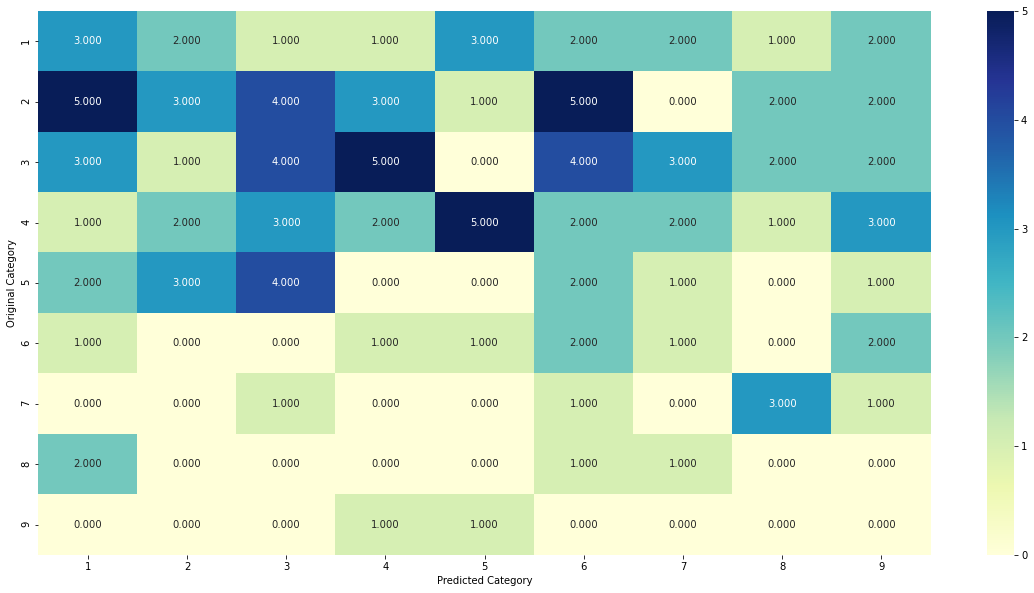

In [90]:
C = confusion_matrix(y_test, predicted_y)
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,10))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Category')
plt.ylabel('Original Category')
plt.show()

In [91]:
import scikitplot as skplt
def evaluate_model(X, y, model=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        model: Classifier to use. If None, default Log reg is use.
    """
    if model is None:
        model = LogisticRegression()
    
    probas = cross_val_predict(model, X, y, cv=StratifiedKFold(n_splits=10), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    plt.figure(figsize=(12,10))
    fig, ax = plt.subplots(figsize=(18, 10))
    #skplt.plot_confusion_matrix(y, preds, ax=ax)
    skplt.metrics.plot_confusion_matrix(y, preds, ax=ax)  # Correct function call
    plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


Log loss: 1.0817139719686815
Accuracy: 0.54182156133829


<Figure size 864x720 with 0 Axes>

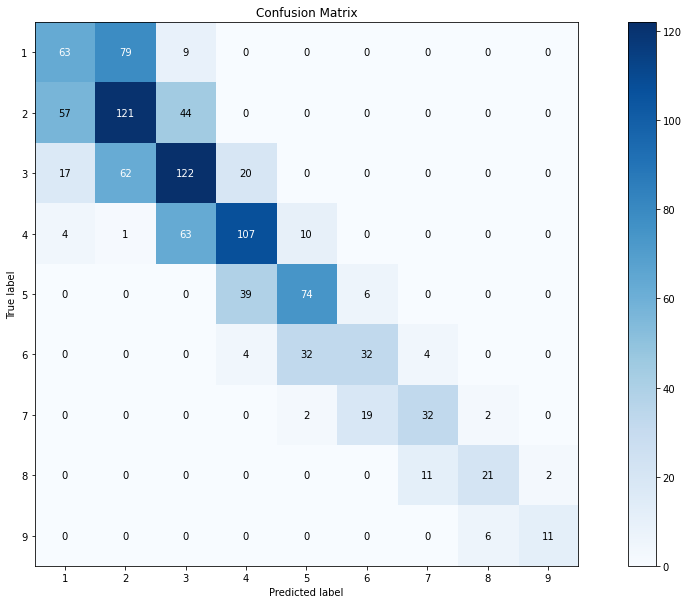

In [92]:
evaluate_model(train_data, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   37.2s remaining:   37.2s


Log loss: 1.3080649902296977
Accuracy: 0.6923791821561338


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.4s finished


<Figure size 864x720 with 0 Axes>

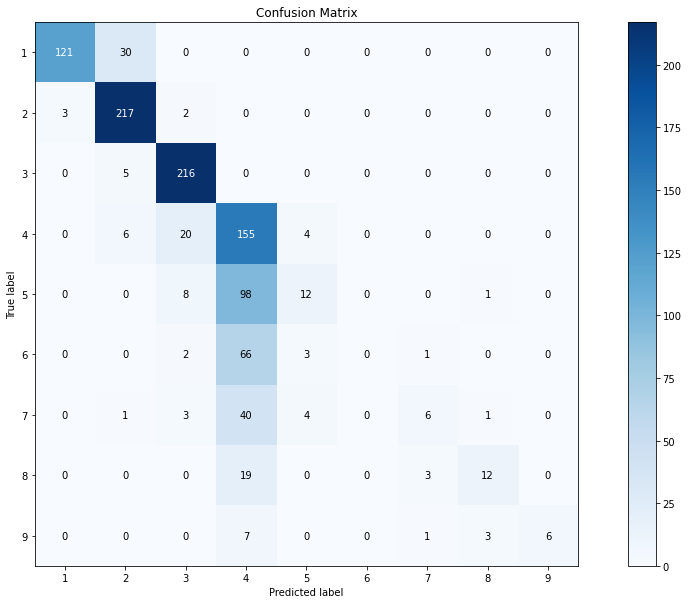

In [93]:
evaluate_model(train_data, y_train, RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 0.501290032506914
Accuracy: 0.758364312267658


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


<Figure size 864x720 with 0 Axes>

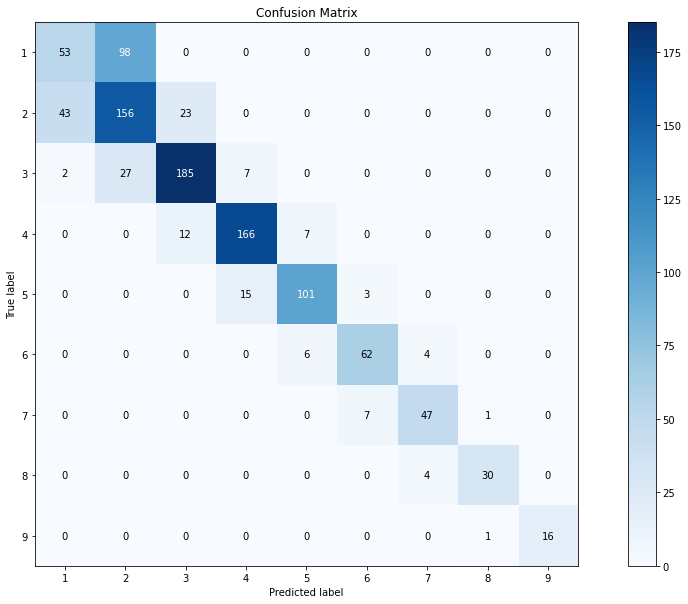

In [94]:
evaluate_model(train_data, y_train, SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 0.11005889689445938
Accuracy: 0.9730483271375465


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


<Figure size 864x720 with 0 Axes>

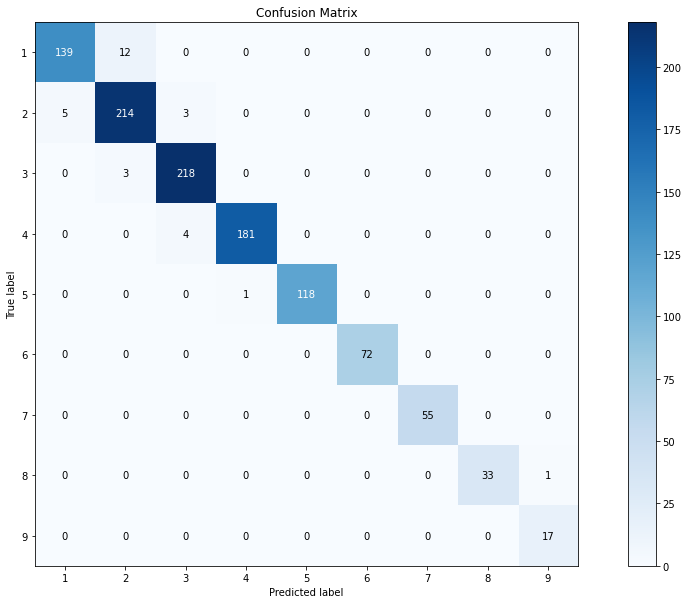

In [95]:
evaluate_model(train_data, y_train,
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

## Now Lets analyze the text column


Log loss: 1.8597285258767473
Accuracy: 0.24535315985130113


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


<Figure size 864x720 with 0 Axes>

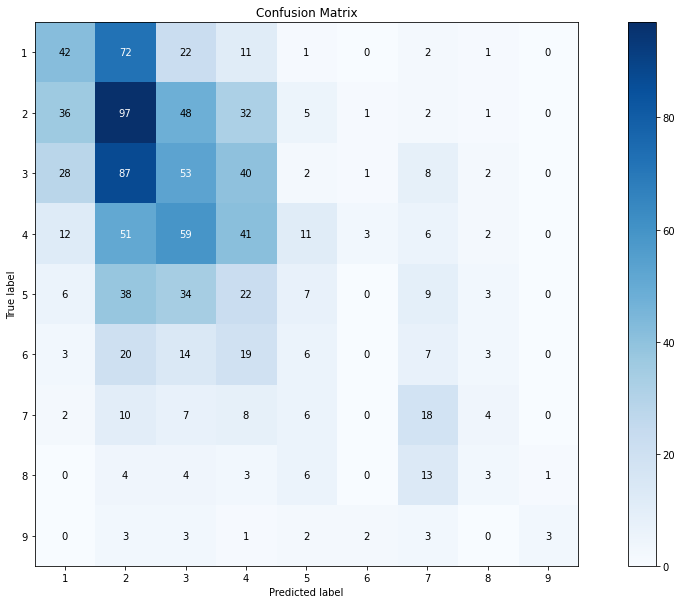

In [96]:
count_vectorizer = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize, 
                                   preprocessor=None, max_features=None)    


bag_of_words = count_vectorizer.fit_transform(X_train['board_rating_reason'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

evaluate_model(truncated_bag_of_words, y_train)


Log loss: 1.8894128152875242
Accuracy: 0.24721189591078066


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


<Figure size 864x720 with 0 Axes>

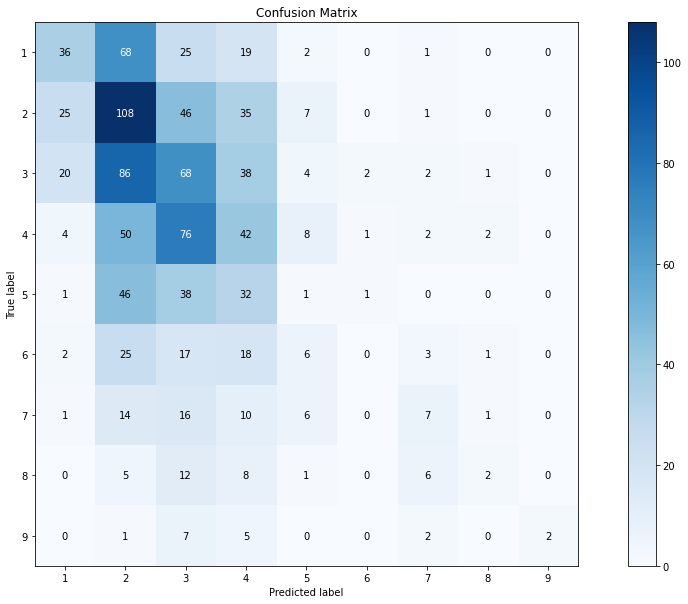

In [97]:
evaluate_model(truncated_bag_of_words, y_train, 
                  RandomForestClassifier(n_estimators=10, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 1.8474689645358033
Accuracy: 0.25


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


<Figure size 864x720 with 0 Axes>

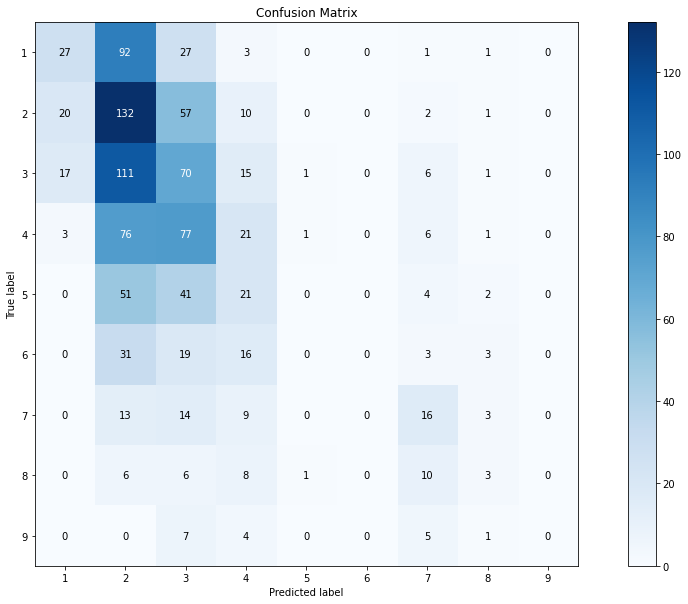

In [98]:
evaluate_model(truncated_bag_of_words, y_train, 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.4s remaining:    5.4s


Log loss: 1.9093590823580342
Accuracy: 0.22397769516728624


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished


<Figure size 864x720 with 0 Axes>

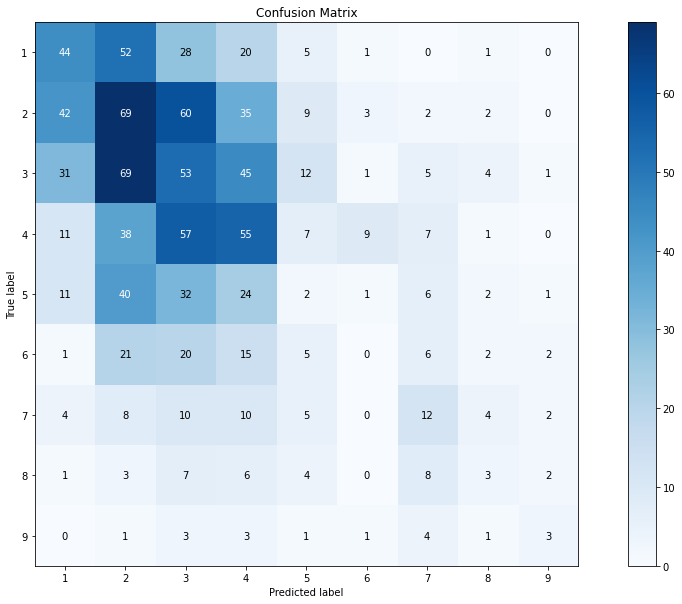

In [99]:
evaluate_model(truncated_bag_of_words, 
                  y_train,
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


Log loss: 1.8597285258767473
Accuracy: 0.24535315985130113


<Figure size 864x720 with 0 Axes>

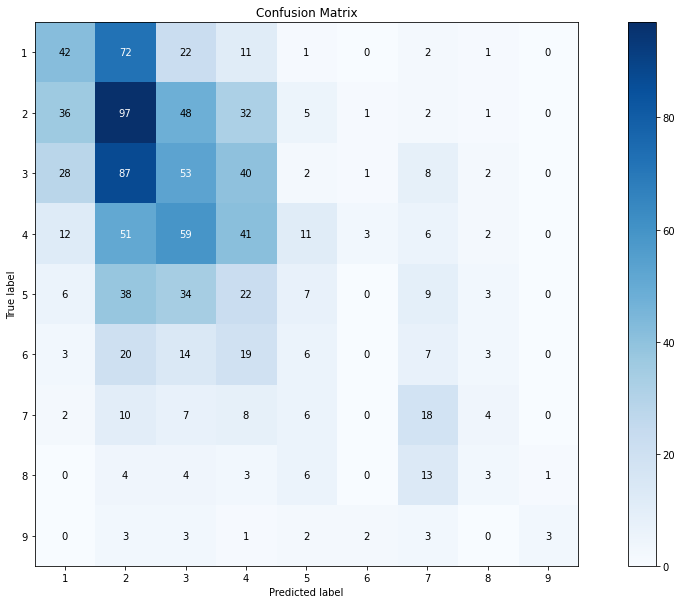

In [100]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, max_features=None)    

tfidf = count_vectorizer.fit_transform(X_train['board_rating_reason'])


svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)

truncated_tfidf = svd.fit_transform(tfidf)

evaluate_model(truncated_tfidf, y_train)

Log loss: 1.887873944830362
Accuracy: 0.24814126394052044


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


<Figure size 864x720 with 0 Axes>

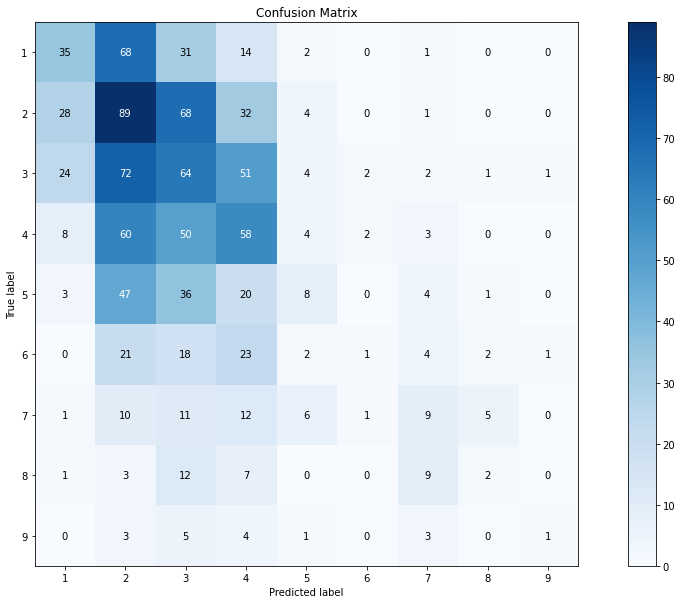

In [101]:
evaluate_model(truncated_tfidf, y_train, 
               RandomForestClassifier(n_estimators=10, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 1.846084655447359
Accuracy: 0.24628252788104088


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


<Figure size 864x720 with 0 Axes>

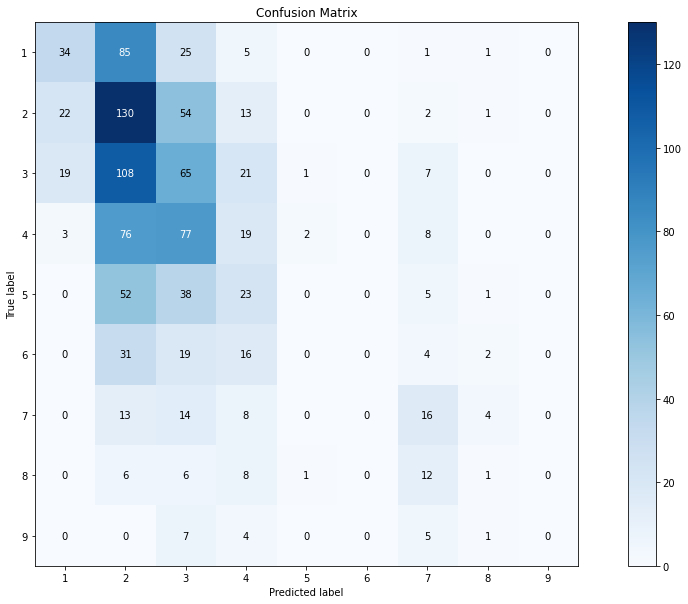

In [102]:
evaluate_model(truncated_tfidf, y_train,
               SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   35.7s remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.9s finished


Log loss: 1.9093590823580342
Accuracy: 0.22397769516728624


<Figure size 864x720 with 0 Axes>

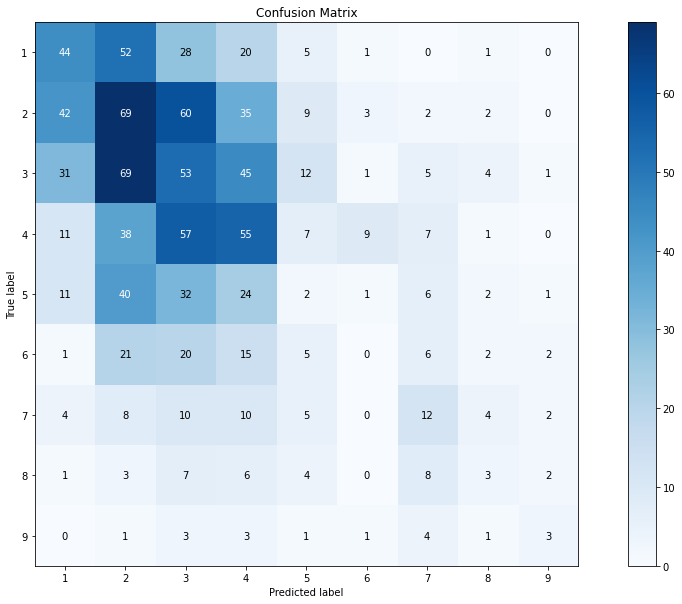

In [103]:
evaluate_model(truncated_tfidf, y_train,
               XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                ))

## Finally combine both text and other data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 1.1411286291916878
Accuracy: 0.5120817843866171


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


<Figure size 864x720 with 0 Axes>

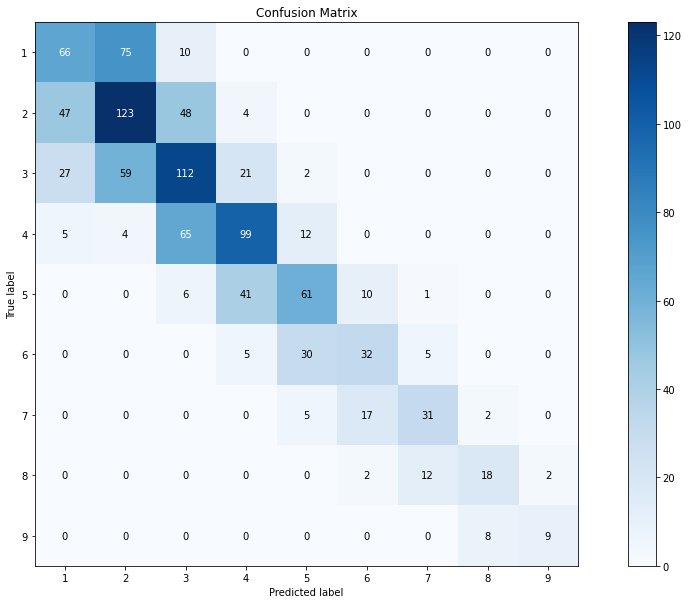

In [104]:
evaluate_model(np.hstack((train_data, truncated_tfidf)), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 0.6033624503647782
Accuracy: 0.733271375464684


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


<Figure size 864x720 with 0 Axes>

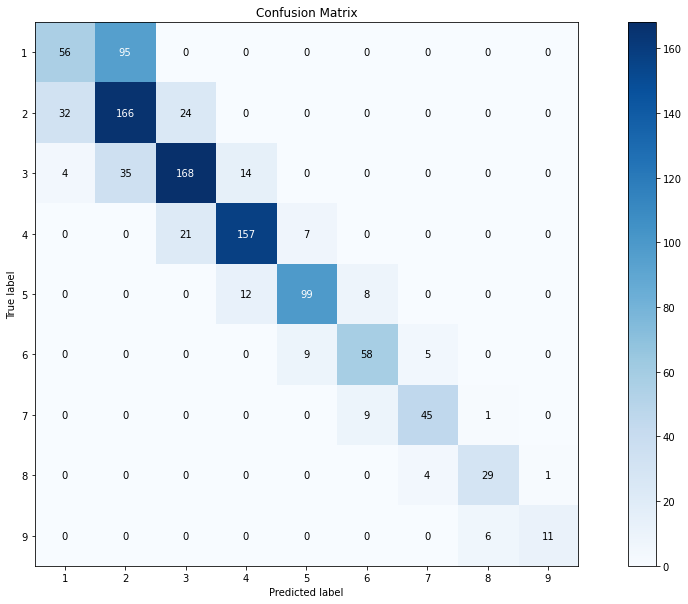

In [105]:
evaluate_model(np.hstack((train_data, truncated_tfidf)), y_train,  SVC(kernel='linear', probability=True)) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 1.3756725610711118
Accuracy: 0.6700743494423792


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


<Figure size 864x720 with 0 Axes>

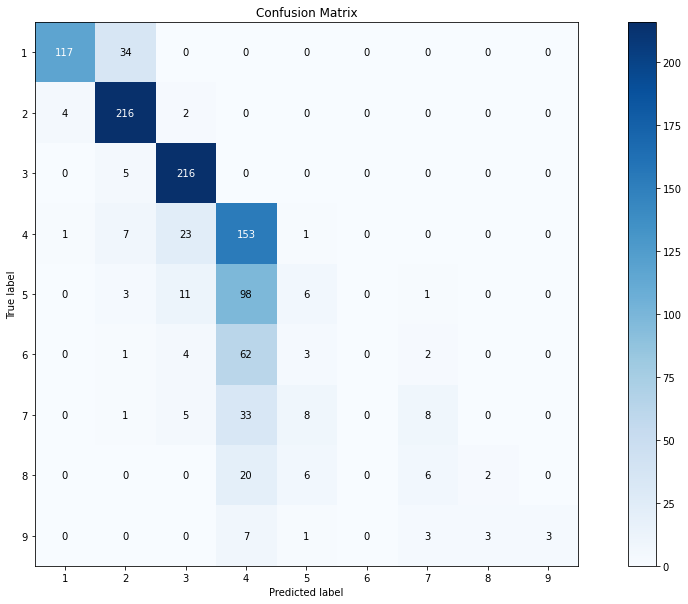

In [106]:
evaluate_model(np.hstack((train_data, truncated_tfidf)), y_train, RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.4s remaining:    5.4s


Log loss: 0.12324013257724645
Accuracy: 0.9674721189591078


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.7s finished


<Figure size 864x720 with 0 Axes>

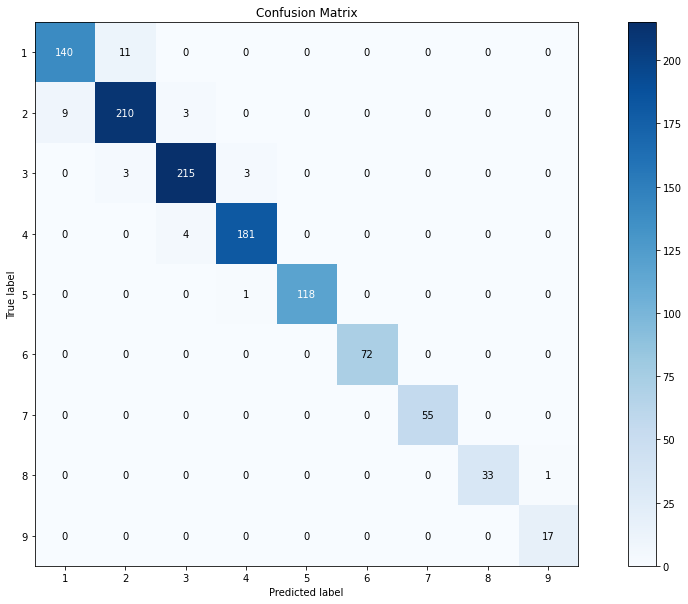

In [107]:
evaluate_model(np.hstack((train_data, truncated_tfidf)), y_train,
              XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

In [108]:
# defining parameter range 
from sklearn.model_selection import GridSearchCV 
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],  
    'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005], 
    'objective': ['multi:softprob']
              }  
  
grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, verbose = 3)
                              
grid.fit(np.hstack((train_data, truncated_tfidf)), y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, objective=multi:softprob;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, objective=multi:softprob;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, objective=multi:softprob;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, objective=multi:softprob;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, objective=multi:softprob;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=4, objective=multi:softprob;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=4, objective=multi:softprob;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=4, objective=multi:softprob;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=4, objective=multi:softprob;, score=nan total time=   0.0s
[CV 5/5] EN

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8], got [1 2 3 4 5 6 7 8 9]

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)              

In [ ]:
model = XGBClassifier(max_depth=2, objective='multi:softprob', learning_rate=0.002)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, max_features=None)    

tfidf = count_vectorizer.fit_transform(X_train['board_rating_reason'])
tfidf_test = count_vectorizer.transform(X_test['board_rating_reason'])
tfidf_predict = count_vectorizer.transform(X_predict['board_rating_reason'])


In [ ]:
svd_text = TruncatedSVD(n_components=25, n_iter=25, random_state=12)

truncated_tfidf_text = svd_text.fit_transform(tfidf)
truncated_tfidf_test_text = svd_text.transform(tfidf_test)
truncated_tfidf_predict_text = svd_text.transform(tfidf_predict)



In [ ]:
truncated_tfidf_text.shape, truncated_tfidf_test_text.shape, truncated_tfidf_predict_text.shape

In [ ]:
evaluate_model(truncated_tfidf_text, y_train)

In [ ]:
print("Unique values in y_train:", np.unique(y_train))
y_train -= 1

In [ ]:
model.fit(np.hstack((train_data, truncated_tfidf_text)), y_train)

In [ ]:
y_predict = model.predict(np.hstack((test_data, truncated_tfidf_test_text)))

In [ ]:
plt.figure(figsize=(12,10))
fig, ax = plt.subplots(figsize=(18, 10))
skplt.metrics.plot_confusion_matrix(y_test, y_predict, ax=ax)
plt.show()

In [ ]:
X_predict_categories = model.predict(np.hstack((predict_data, truncated_tfidf_predict_text)))

In [ ]:
X_predict['Category'] = X_predict_categories

In [ ]:
X_predict.head(2)

In [ ]:
X_predict.to_csv(r'./ScoringSheet.csv',index=False)

In [ ]:
df = pd.read_csv(r'./ScoringSheet.csv')
df.head(2)